# IMPORT

In [1]:
import pandas as pd

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

# DATA LOAD

In [ ]:
rtn_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [ ]:
df3=rtn_df[['Date','코스피']]
df3.Date=pd.to_datetime(df3.Date)
df3=df3.set_index('Date')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
rtn_df['Date']=pd.to_datetime(rtn_df['Date'])
rtn_df=rtn_df.set_index('Date')
rtn_df=rtn_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

# train, test 기간설정

<pre>
하락장 : 2020-02-26 ~ 2020-04-06
상승장 : 2020-04-06 ~ 2020-06-26
1. MACD 하락 - 상승 : 2020-02-26 ~ 2020-06-26 
2. 종가 하락 - 상승 : 2020-02-26 ~ 2020-06-05
3. CLI 상승 & 주가 하락 : 2019-10-31 ~ [2019-11-01 : 2020-04-30] 
 -- MACD 안전핀 장착 : [2019-11-01 : 2020-06-26] 
4. CLI 하락 & : 주가 하락 
* train 
down_2019=[:'2019-11-01']
down_2020=['2020-05-02':'2021-07-31']
* test
kospi_down=[2021-08-01 : ]


In [ ]:
# # 하락장
# rtn_df_train = rtn_df.loc[:'2019-10-31'] # Train set
# rtn_df_test = rtn_df.loc['2019-09-06':] # Test set (using MA)

In [ ]:
# # 상승장
# rtn_df_train=rtn_df.loc[:'2019-10-31'] # Train set
# rtn_df_test=rtn_df.loc['2020-02-11':'2021-07-31']  # Test set


In [ ]:
# # 최근하락장 
# rtn_df_train=rtn_df.loc[:'2019-10-31'] # Train set
# rtn_df_test=rtn_df.loc['2021-06-05':]  # Test set

In [ ]:
# 최근하락장 
rtn_df_train=rtn_df.loc[:'2019-10-31'] # Train set
rtn_df_test=rtn_df.loc['2019-09-06':] # Test set

# 학습 데이터 생성

In [ ]:
# Markowitz's Portfolio Network (MPN)을 이용해서 최적 포트폴리오를 구축한다.
#
# 1. 학습 데이터와 평가 데이터 생성 모듈.
#
# 참고 : https://blog.naver.com/chunjein/222492404960/
#        https://blog.naver.com/chunjein/222494724278
#        https://blog.naver.com/chunjein/222496640766
#
# 2021.08.27   blog.naver.com/chunjein (조성현)
# ------------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle


N_STOCKS = 7  # 포트폴리오를 구성할 주식 종목 개수
N_TIME = 20    # look back window size
N_FUTURE = 20  # 미래 20 기간의 최적 포트폴리오를 추정할 예정이다.


# 1. 학습과 performance-test에 사용할 데이터를 생성한다.
# --------------------------------------------------
# 수익률 sequence 데이터를 생성한다.
def make_sequence(x):
    T = N_TIME + N_FUTURE
    x_seq = np.expand_dims(np.array(x.iloc[0:T, :]), 0)
    
    for i in range(1, len(x) - T + 1):
        d = np.expand_dims(np.array(x.iloc[i:(i+T), :]), 0)
        x_seq = np.concatenate((x_seq, d))
        
    return x_seq

# 학습 데이터와 시험 데이터를 생성한다. 시험 데이터는 향후 performance test용으로
# 사용한다. 학습 데이터 80%, 시험 데이터 20%
n = int(rtn_df.shape[0] * 0.9)
rtn_train = make_sequence(rtn_df_train)
rtn_test = make_sequence(rtn_df_test)   # 이 데이터는 학습에 사용하지 않는다.
 
print("# 수익률 sequence 데이터를 생성했습니다.")

# 2. 학습에 사용할 데이터를 생성한다.
# -------------------------------
# 다음 기간 (N_FUTURE 기간)을 학습/예측하도록 데이터를 구성한다.
xc_train = np.array([x[:N_TIME] for x in rtn_train])
xf_train = np.array([x[-N_FUTURE:] for x in rtn_train])
                     
xc_test = np.array([x[:N_TIME] for x in rtn_test])
xf_test = np.array([x[-N_FUTURE:] for x in rtn_test])

# 4.performace_test.py에서 성과 차트를 그릴 때 x축 인덱스로 사용하기 위해
# xf_test[0][0] 위치부터 끝까지 날짜를 기록해 둔다.
test_date = rtn_df_test[N_TIME:].index


# 수익률 sequence 데이터를 생성했습니다.


# 모델 학습

In [ ]:
# random seed 값 고정
np.random.seed(3)
tf.random.set_seed(3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 420       
                                                                 
 dense (Dense)               (None, 7)                 56        
                                                                 
 activation (Activation)     (None, 7)                 0         
                                                                 
Total params: 476
Trainable params: 476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
55/55 [==============================] - 4s 28ms/step - loss: -1.0107 - val_loss: -2.8374
Epoch 2/1000
55/55 [==============================] - 1s 13ms/step - loss: -1.0053 - val_loss: -2.8374
Epoch 3/1000
55/55 [==============================] - 1s 12ms/step - loss: -1.0048 - val_loss: -2.8373
Epoch 4/1000


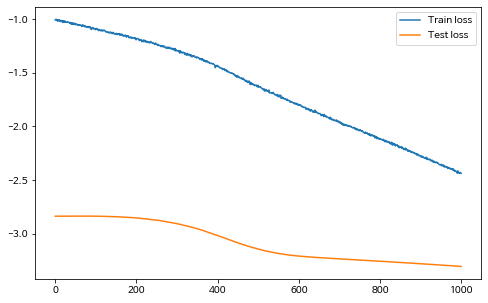

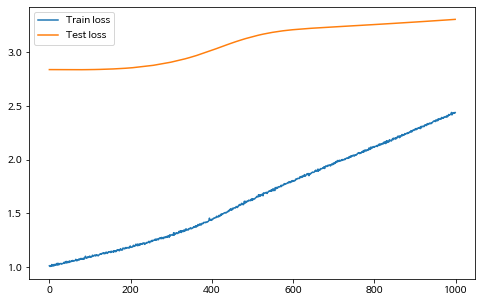

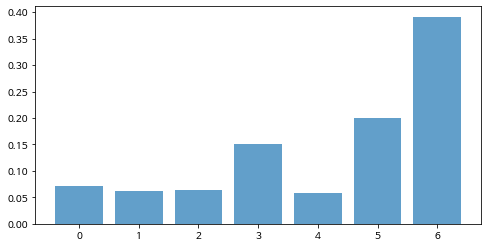

In [ ]:
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') *100
xf_train = xf_train.astype('float32') *100
xc_test = xc_test.astype('float32') *100
xf_test = xf_test.astype('float32') *100


N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
#xc_train, xf_train = shuffle(xc_train, xf_train)

# Markowitz Network를 생성한다.
# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.00
REG_CONST = 0.0
SAVE_MODEL = 'data/3-1.MPN_LSTM.h5'

# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# Markowitz Network에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)   # W = (None, 1, 50)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2) # R = (None, 50, 1)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_sum(objective, axis=0)


lstm = LSTM( units = 7, # units의 값은 layer 통일이 제일 효과적이다.
             input_shape=(N_TIME, N_STOCKS),  #(4980, 20, 5)  --> (20,5),    
             dropout=0.0,
             recurrent_dropout=0.0,
             return_sequences=False
      )
model = Sequential()
model.add( lstm )
model.add( Dense(N_STOCKS, activation='tanh') )
model.add(Activation('softmax'))


# 마코비츠의 최적 weights
with tf.device("/device:GPU:0"):
    #y_output = Activation('softmax')(y_output)

    
    model.compile(loss = markowitz_objective, 
                optimizer = Adam(learning_rate = 1e-5),
                )
    stop = EarlyStopping(patience=10, monitor='val_loss')

    model.summary()

    # MPN을 학습하고 결과를 저장한다.
    hist = model.fit(xc_train, xf_train, epochs=1000, batch_size = 64, 
                     #callbacks=[stop],
                    validation_data = (xc_test, xf_test))
    #model.save(SAVE_MODEL)

# loss trajectory를 확인한다.
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.negative(hist.history['loss']), label='Train loss')
plt.plot(np.negative(hist.history['val_loss']), label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 확인용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()
    
check_w(0)

# 백테스팅

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Markowitz's Portfolio Network (MPN)을 이용해서 최적 포트폴리오를 구축한다.
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 모델을 가져온다.
lstm_model = model

# MPN을 이용해서 백 테스트를 수행한다.
# --------------------------------
lstm_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_hist_lstm = []
for i in range(0, xc_test.shape[0], N_FUTURE):
    # LSTM으로 W를 추정한다.
    x = xc_test[i][np.newaxis,:, :]
    w_lstm = lstm_model.predict(x)[0]
    w_hist_lstm.append(w_lstm)
    
    # 다음 기의 누적 수익률
    m_rtn = np.sum(xf_test[i]/100, axis = 0)
    
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    lstm_value.append(lstm_value[-1] * np.exp(np.dot(w_lstm, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    

print('\nBack test를 완료했습니다.')



Back test를 완료했습니다.


# 포트폴리오 성과 평가

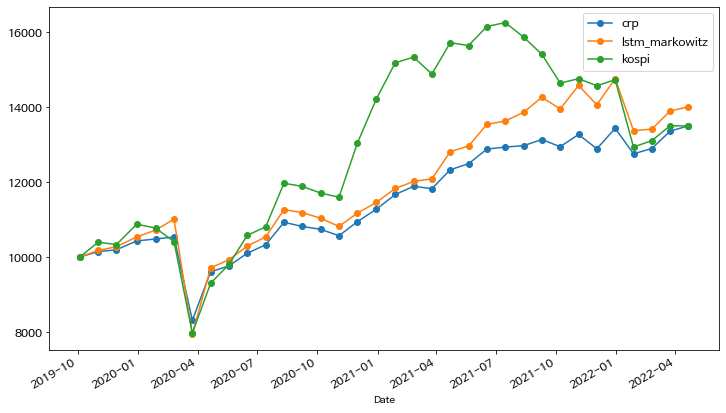

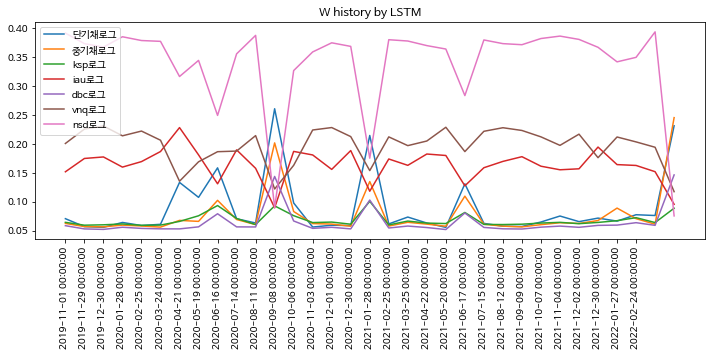


포트폴리오 수익률 (연간):
crp_rtn      0.109275
lstm_rtn     0.122685
sp500_rtn    0.109166
dtype: float64

포트폴리오 위험 (연간):
crp_rtn      0.054573
lstm_rtn     0.075087
sp500_rtn    0.073117
dtype: float64

Sharp Ratio :
crp_rtn      2.002356
lstm_rtn     1.633910
sp500_rtn    1.493035
dtype: float64


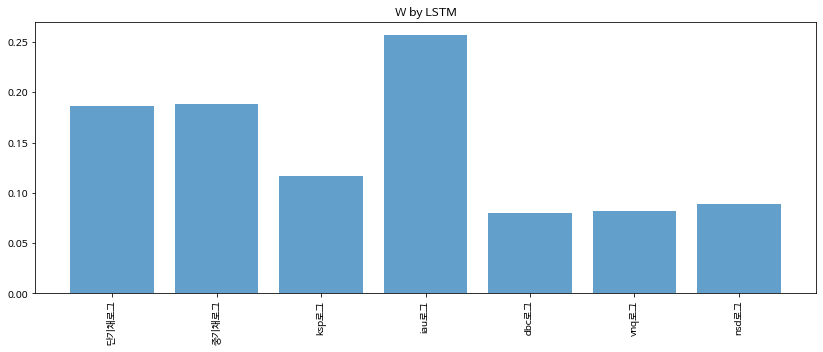

In [ ]:
# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, len(test_date), N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 
                        'lstm_markowitz':lstm_value
                        }, 
                       index=test_date[idx])

# S&P500 index와 포트폴리오 성과를 비교해 본다.
sp500 = pd.DataFrame(df3['코스피'])

# 수익률을 계산해서 perf_df와 시작 위치를 맞춘다 (초기 value를 맞춘다).
sp500 = sp500[test_date[0]:]
sp_trans = lstm_value[0] / sp500['코스피'][0]
perf_df['kospi'] = sp500['코스피'] * sp_trans

# S&P500 index (시장), CRP, 그리고 MPN의 성과를 비교한다.
p = perf_df.plot(figsize=(12, 7), style = '-o', fontsize=12)
p.legend(fontsize=12)
##그래프저장
plt.show()

# weights history를 확인한다.
w_hist_lstm = np.array(w_hist_lstm)

# 종목 이름을 읽어온다.
symbol = rtn_df.columns

n = 7
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.plot(w_hist_lstm[:, i], label=symbol[i])
plt.legend(loc='upper left')
plt.title('W history by LSTM')
plt.xticks(np.arange(0, 31), list(perf_df.index[1:]), rotation='vertical')
plt.show()

# 포트폴리오 수익률, 위험, SR을 측정한다.
rp_df = perf_df.copy()
rp_df['crp_rtn'] = np.log(rp_df['crp']) - np.log(rp_df['crp'].shift(1))
rp_df['lstm_rtn'] = np.log(rp_df['lstm_markowitz']) - np.log(rp_df['lstm_markowitz'].shift(1))
rp_df['sp500_rtn'] = np.log(rp_df['kospi']) - np.log(rp_df['kospi'].shift(1))
rp_df = rp_df.dropna()

# 포트폴리오 수익률 (연간)
rp = rp_df[['crp_rtn', 'lstm_rtn', 'sp500_rtn']].mean()
# 20일 = 약 1개월, 1년 = 12개월
rp*=12
print('\n포트폴리오 수익률 (연간):')
print(rp)

# 포트폴리오 위험 (연간 표준편차)
sp = rp_df[['crp_rtn', 'lstm_rtn', 'sp500_rtn']].std()
print('\n포트폴리오 위험 (연간):')
print(sp)

# Sharp ratio
print('\nSharp Ratio :')
print(rp / sp)

# 최적 포트폴리오 결과 확인용 코드 (참고용)
def check_w(n = 0):
    plt.figure(figsize=(14,5))
    x = xc_test[n][np.newaxis,:,:] * 20.0
    w_lstm = lstm_model.predict(x)[0]
    plt.bar(np.arange(N_STOCKS), w_lstm, alpha = 0.7)
    plt.xticks(np.arange(7), list(symbol), rotation='vertical')
    plt.title('W by LSTM')
    plt.show()
    
check_w(0)

## 가중치 DF 저장 (일자별)

In [ ]:
w_hist_lstm = []
for i in range(0, xc_test.shape[0]):
    # LSTM으로 W를 추정한다.
    x = xc_test[i][np.newaxis,:, :]
    w_lstm = lstm_model.predict(x)[0]
    w_hist_lstm.append(w_lstm)


In [ ]:
idx = np.arange(0, len(test_date))
date=test_date[idx]

In [ ]:
len(w_hist_lstm)

655

In [ ]:
W_df=pd.DataFrame(w_hist_lstm[:-1],columns=rtn_df.columns,index=list(date)[20:])
W_df

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
2019-11-01,0.070710,0.062559,0.064387,0.151743,0.058623,0.200637,0.391341
2019-11-04,0.065812,0.060589,0.063805,0.162688,0.056678,0.205922,0.384506
2019-11-05,0.067245,0.061147,0.061924,0.157896,0.056730,0.210646,0.384412
2019-11-06,0.073908,0.061602,0.062522,0.154640,0.058226,0.198351,0.390752
2019-11-07,0.072361,0.061414,0.063550,0.154560,0.058064,0.199581,0.390471
...,...,...,...,...,...,...,...
2022-05-04,0.101756,0.081277,0.071479,0.140501,0.066460,0.185728,0.352800
2022-05-05,0.150888,0.108821,0.079488,0.133534,0.075061,0.169397,0.282811
2022-05-06,0.184240,0.166338,0.078879,0.140856,0.079791,0.152470,0.197427
2022-05-09,0.227282,0.172593,0.083706,0.122467,0.090873,0.148507,0.154572


In [ ]:
# W_df.to_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치(일자별).csv")


# 타 펀드 비교(KB)

In [ ]:
kb=pd.read_excel("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/kb아무것도못하쥬.xlsx")
kb.일자=pd.to_datetime(kb.일자)
kb=kb.set_index('일자')
#일자설정
kb=kb.loc[perf_df.index[0]:perf_df.index[-1]]
kb['금액']=10000
kb['수익률(%)']=kb['수익률(%)']*0.01
for i in range(1,kb.shape[0]):
    kb.iloc[i,1]=kb.iloc[i,0]*kb.iloc[i-1,1]+kb.iloc[i-1,1]
p_df=perf_df.copy()
p_df=p_df.reset_index()
kb=kb.reset_index()
grp=pd.merge(p_df,kb,left_on='Date',right_on='일자',how='outer')
grp=grp.set_index('Date')
grp=grp[['crp', 'lstm_markowitz', 'kospi', '금액']]
grp.columns=['crp', 'lstm_markowitz', 'kospi', 'KB펀드']
grp=grp.dropna()

# 타 펀드 비교 <미래에셋>

In [ ]:
fa=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/미래에셋.csv")
fa=fa.T
fa=fa.iloc[1:]
fa=fa.reset_index()
fa['index']=pd.to_datetime(fa['index'])
fa=fa.set_index('index')
fa.columns=['투자수익률','비교지수']
fa['미래에셋']=fa['투자수익률']*0.01*10000+10000
fa['미래에셋_pct']=fa['미래에셋'].pct_change(1)
#일자설정
fa=fa.loc[perf_df.index[0]:perf_df.index[-1]]
fa['미래에셋']=10000
for i in range(1,fa.shape[0]):
    fa.iloc[i,2]=fa.iloc[i,3]*fa.iloc[i-1,2]+fa.iloc[i-1,2]
fa=fa.reset_index()
fa['index']=pd.to_datetime(fa['index'])
grp=pd.merge(grp.reset_index(),fa[['index','미래에셋']],left_on='Date',right_on='index',how='outer')
grp=grp[['Date','lstm_markowitz','kospi','미래에셋','KB펀드']]
grp=grp.dropna()
grp=grp.set_index('Date')

In [ ]:
ㅇㅁㄻㄴㅇㄻㄴㅇㄻㄴㅇㄻㄴㅇㄹㄴㅇㄹ

NameError: ignored

# 차트 이미지 저장

In [ ]:
# p = grp.plot(figsize=(12, 7), style = '-o', fontsize=12)
# p.legend(fontsize=12)
# plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
# plt.show()

# 주식 전략 결합

## 공격투자형

In [ ]:
log_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피
0,2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493,0,1371.589966
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0,1367.699951
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0,1328.949951
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0,1344.760010
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0,1316.670044
...,...,...,...,...,...,...,...,...,...,...
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0,2677.570068
4193,2022-05-05,0.000000,0.000000,0.000000,-0.004196,-0.005292,-0.027030,-0.033019,0,2677.570068
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0,2644.510010
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0,2644.510010


In [ ]:
log_df['Date']=pd.to_datetime(log_df['Date'])

In [ ]:
r_df=pd.read_csv("/content/gdrive/MyDrive/FINAL TEAM/파이널프로젝트/비주식팀/Data/주식전략/로그수익률전체_10종목.csv")

In [ ]:
r_df=r_df.fillna(0)

In [ ]:
r_df.columns

Index(['Unnamed: 0', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법'],
      dtype='object')

In [ ]:
r_df['Unnamed: 0']=pd.to_datetime(r_df['Unnamed: 0'])
r_df.columns=['Date', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']
r_df=r_df.set_index('Date')

In [ ]:
r_df

,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
Date,,,,,,,,,,
2005-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-04-04,-0.001885,-0.003509,0.003417,0.015300,-0.004737,-0.000839,-0.000324,-0.002091,-0.012773,-0.001492
2005-04-06,-0.005572,0.012566,0.005841,-0.002118,0.011094,0.000858,0.002884,0.007565,-0.000898,0.017410
2005-04-07,-0.002721,-0.010705,-0.004159,-0.001387,-0.001534,-0.002636,0.001947,0.000370,0.000927,-0.009234
2005-04-08,-0.002758,-0.003010,-0.001109,-0.000854,0.002285,-0.004228,0.010989,-0.000463,0.009500,0.006397
...,...,...,...,...,...,...,...,...,...,...
2022-05-10,-0.015892,-0.004799,-0.002160,-0.009955,-0.010384,-0.003993,-0.004541,-0.006504,-0.001658,-0.015276
2022-05-11,0.018021,0.000791,-0.003038,0.012060,0.009773,0.009442,0.009268,0.013275,-0.007461,0.018093
2022-05-12,-0.024158,-0.029275,-0.013050,-0.001186,-0.011456,-0.006010,-0.020785,-0.035540,-0.003394,0.005001


In [ ]:
# r_df= r_df.reset_index()
log_df=pd.merge(log_df,r_df, on='Date', how='outer').dropna()

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0.0,1367.699951,-0.004163,0.003148,-0.004245,-0.009235,-0.004180,-0.002885,-0.011703,0.003138,0.001468,0.007272
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0.0,1328.949951,-0.016589,-0.022778,-0.017546,-0.022754,-0.024339,-0.019855,-0.019931,-0.023816,-0.042204,-0.022764
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0.0,1344.760010,0.011637,0.011190,0.004478,0.003144,0.012759,0.010315,0.011755,0.010877,0.021549,0.014470
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0.0,1316.670044,-0.016843,-0.028491,-0.011694,-0.002772,-0.025226,-0.013850,-0.019911,-0.026519,-0.021908,-0.025480
5,2006-03-08,0.000203,0.000818,-0.001992,-0.019625,-0.016154,0.005173,0.007549,0.0,1314.050049,-0.007919,-0.004598,0.010290,0.001887,-0.014189,-0.006048,-0.010333,-0.003670,0.000692,-0.003637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,0.002114,-0.006505,-0.008353,-0.003740,0.001091,-0.004454,-0.004513,-0.006798,-0.001810,-0.008891
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,-0.009320,-0.003745,-0.006407,0.001788,-0.004029,-0.000976,0.000924,-0.002858,0.006830,0.002055
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,0.001078,-0.013734,-0.006216,-0.013486,-0.012977,-0.015054,-0.014405,-0.012405,-0.008364,-0.006202
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,-0.016910,-0.011615,-0.028295,-0.018643,-0.011348,-0.021987,-0.013603,-0.014154,-0.013436,-0.006623


In [ ]:
log_df = log_df.set_index('Date')

## 공격투자형

In [ ]:
극안전형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/극안전형.csv")
안전추구형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/안전추구형.csv")
위험중립형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/위험중립형.csv")
적극투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/적극투자형.csv")
공격투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/공격투자형.csv")

In [ ]:
공격투자형 = 공격투자형[[
 'Unnamed: 0.1',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']]


In [ ]:
# 극안전형.columns=['Date', '단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw',
#        'nsdw']
공격투자형.columns=[ 'Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']
공격투자형.Date=pd.to_datetime(공격투자형.Date)

In [ ]:
공격투자형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.193817,0.285052,0.091506,0.145008,0.071907,0.111367,0.101343
1,2019-11-04,0.226288,0.290042,0.082231,0.147596,0.060219,0.094862,0.098762
2,2019-11-05,0.243892,0.286038,0.078764,0.135360,0.062584,0.097352,0.096009
3,2019-11-06,0.252635,0.301300,0.081177,0.121597,0.068710,0.094398,0.080183
4,2019-11-07,0.264906,0.295634,0.082882,0.112138,0.067407,0.094465,0.082568
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.090333,0.089126,0.070085,0.240231,0.057150,0.140984,0.312092
650,2022-05-05,0.149126,0.140296,0.078429,0.207092,0.065338,0.131073,0.228646
651,2022-05-06,0.244518,0.215061,0.070939,0.177272,0.066915,0.103003,0.122291
652,2022-05-09,0.274199,0.206254,0.076141,0.154980,0.073314,0.105774,0.109338


In [ ]:
log_df=pd.merge(log_df,공격투자형,on='Date',how='inner')

In [ ]:
공격투자형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.193817,0.285052,0.091506,0.145008,0.071907,0.111367,0.101343
1,2019-11-04,0.226288,0.290042,0.082231,0.147596,0.060219,0.094862,0.098762
2,2019-11-05,0.243892,0.286038,0.078764,0.135360,0.062584,0.097352,0.096009
3,2019-11-06,0.252635,0.301300,0.081177,0.121597,0.068710,0.094398,0.080183
4,2019-11-07,0.264906,0.295634,0.082882,0.112138,0.067407,0.094465,0.082568
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.090333,0.089126,0.070085,0.240231,0.057150,0.140984,0.312092
650,2022-05-05,0.149126,0.140296,0.078429,0.207092,0.065338,0.131073,0.228646
651,2022-05-06,0.244518,0.215061,0.070939,0.177272,0.066915,0.103003,0.122291
652,2022-05-09,0.274199,0.206254,0.076141,0.154980,0.073314,0.105774,0.109338


In [ ]:
log_df

,Date,단기채로그_x,중기채로그_x,ksp로그_x,iau로그_x,dbc로그_x,vnq로그_x,nsd로그_x,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채로그_y,중기채로그_y,ksp로그_y,iau로그_y,dbc로그_y,vnq로그_y,nsd로그_y
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.193817,0.285052,0.091506,0.145008,0.071907,0.111367,0.101343
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.226288,0.290042,0.082231,0.147596,0.060219,0.094862,0.098762
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.243892,0.286038,0.078764,0.135360,0.062584,0.097352,0.096009
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.252635,0.301300,0.081177,0.121597,0.068710,0.094398,0.080183
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.264906,0.295634,0.082882,0.112138,0.067407,0.094465,0.082568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.277189,0.206373,0.073767,0.169978,0.069086,0.096894,0.106714
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.090333,0.089126,0.070085,0.240231,0.057150,0.140984,0.312092
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.244518,0.215061,0.070939,0.177272,0.066915,0.103003,0.122291
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.274199,0.206254,0.076141,0.154980,0.073314,0.105774,0.109338


In [ ]:
log_df.columns = ['Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그',
 '상승',
 '코스피',
 '유동성기법',
 '레버리지기법',
 '그레이엄기법',
 '린치기법',
 '버핏기법',
 '삼대투자기법',
 '성장성기법',
 '수익성기법',
 '시장가치기법',
 '활동성기법',
 '단기채w',
 '중기채w',
 'kspw',
 'iauw',
 'dbcw',
 'vnqw',
 'nsdw']

In [ ]:
# log_df = log_df[['Date','단기채로그_y', '중기채로그_y', 'ksp로그_y', 'iau로그_y', 'dbc로그_y', 'vnq로그_y', 'nsd로그_y' ,'상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
#  '성장성기법', '수익성기법', '시장가치기법', '활동성기법' ]]

In [ ]:
# log_df.columns = ['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그', '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법', '성장성기법',
#  '수익성기법', '시장가치기법', '활동성기법']

In [ ]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    623 non-null    datetime64[ns]
 1   단기채로그   623 non-null    float64       
 2   중기채로그   623 non-null    float64       
 3   ksp로그   623 non-null    float64       
 4   iau로그   623 non-null    float64       
 5   dbc로그   623 non-null    float64       
 6   vnq로그   623 non-null    float64       
 7   nsd로그   623 non-null    float64       
 8   상승      623 non-null    float64       
 9   코스피     623 non-null    float64       
 10  유동성기법   623 non-null    float64       
 11  레버리지기법  623 non-null    float64       
 12  그레이엄기법  623 non-null    float64       
 13  린치기법    623 non-null    float64       
 14  버핏기법    623 non-null    float64       
 15  삼대투자기법  623 non-null    float64       
 16  성장성기법   623 non-null    float64       
 17  수익성기법   623 non-null    float64       
 18  시장가치기법  62

In [ ]:
#기간별로 정렬
log_df=log_df.sort_values(by=['Date'], ascending=True)
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.193817,0.285052,0.091506,0.145008,0.071907,0.111367,0.101343
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.226288,0.290042,0.082231,0.147596,0.060219,0.094862,0.098762
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.243892,0.286038,0.078764,0.135360,0.062584,0.097352,0.096009
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.252635,0.301300,0.081177,0.121597,0.068710,0.094398,0.080183
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.264906,0.295634,0.082882,0.112138,0.067407,0.094465,0.082568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.277189,0.206373,0.073767,0.169978,0.069086,0.096894,0.106714
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.090333,0.089126,0.070085,0.240231,0.057150,0.140984,0.312092
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.244518,0.215061,0.070939,0.177272,0.066915,0.103003,0.122291
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.274199,0.206254,0.076141,0.154980,0.073314,0.105774,0.109338


In [ ]:
log_df.index = log_df['Date']


In [ ]:
# 극안전형_df=극안전형_df.fillna(method='ffill').dropna()

In [ ]:
log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]=log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']].cumsum()

In [ ]:
log_df[['유동성w', '레버리지w','그레이엄w', '린치w', '버핏w', '삼대투자w','성장성w', '수익성w', '시장가치w', '활동성w']]=log_df[['유동성기법','레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']].cumsum()

In [ ]:
# log_df[['단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw', 'nsdw','유동성기법', '레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법','성장성기법', '수익성기법', '시장가치기법', '활동성기법'
# ,'단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasd

NameError: ignored

In [ ]:
log_df['금액']=10000

In [ ]:
log_df['kospi']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['ksp로그'])
log_df['유동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['유동성w'])
log_df['레버리지']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['레버리지w'])
log_df['그레이엄']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['그레이엄w'])
log_df['린치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['린치w'])
log_df['버핏']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['버핏w'])
log_df['삼대투자']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['삼대투자w'])
log_df['성장성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['성장성w'])
log_df['수익성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['수익성w'])
log_df['시장가치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['시장가치w'])
log_df['활동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['활동성w'])







In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasdf

NameError: ignored

In [ ]:
log_df.columns

Index(['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그', '상승',
       '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법', '성장성기법',
       '수익성기법', '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw', 'dbcw',
       'vnqw', 'nsdw', '유동성w', '레버리지w', '그레이엄w', '린치w', '버핏w', '삼대투자w', '성장성w',
       '수익성w', '시장가치w', '활동성w', '금액', 'kospi', '유동성', '레버리지', '그레이엄', '린치',
       '버핏', '삼대투자', '성장성', '수익성', '시장가치', '활동성'],
      dtype='object')

In [ ]:
grp

,lstm_markowitz,kospi,미래에셋,KB펀드
Date,,,,
2019-10-04,10000.000000,10000.000000,10000.000000,10000.000000
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894


In [ ]:
log_df


,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,유동성기법,...,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,0.000157,...,10006.816368,10020.048002,10015.106332,10011.550830,10017.519005,10013.700084,10013.999270,10018.848772,10014.115209,10019.660482
2019-11-04,0.000168,-0.002161,0.022195,-0.002077,0.024486,-0.007237,-0.011898,0.0,2130.239990,0.014403,...,9999.523801,10002.005233,9995.464548,9998.863375,9996.544884,10001.129834,10006.011343,10005.546822,10001.453012,10015.282588
2019-11-05,0.000232,-0.001148,0.027999,-0.018849,0.027029,-0.024367,-0.013624,0.0,2142.639893,0.014618,...,9976.050762,9966.238732,9960.953593,9966.730350,9964.489164,9964.057393,9973.837562,9975.620155,9974.657477,9983.311479
2019-11-06,0.000255,-0.001098,0.028704,-0.013928,0.016176,-0.022196,0.001502,0.0,2144.149902,-0.001131,...,9995.299921,9982.174331,9977.372392,9987.004551,9978.060767,9979.229231,10005.676729,9987.180211,9996.510151,10001.112530
2019-11-07,0.000278,-0.001796,0.028769,-0.030188,0.015534,-0.032221,0.007589,0.0,2144.290039,0.001447,...,9973.784559,9959.969241,9952.762573,9965.796872,9959.143847,9960.611196,9978.981619,9964.739586,9978.235965,9985.032252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,0.028070,-0.002431,0.251949,0.144817,0.652885,0.173650,0.408839,0.0,2680.459961,0.002114,...,11586.876771,11697.139441,12027.987218,11874.364830,11852.565236,11984.440657,11821.174592,11549.059586,12132.719568,11723.567362
2022-05-04,0.028154,-0.003295,0.250870,0.154636,0.683612,0.185075,0.423056,0.0,2677.570068,-0.009320,...,12804.493099,12912.158177,13222.629189,13084.709091,13059.033917,13186.786295,13033.375805,12772.490633,13336.248072,12941.376458
2022-05-06,0.028263,-0.002294,0.238446,0.156597,0.684673,0.173135,0.406062,0.0,2644.510010,0.001078,...,11719.146271,11817.849334,12135.415687,11990.337950,11965.127186,12090.754985,11938.323204,11679.147463,12247.286314,11852.506312


In [ ]:
log_df =log_df.drop('Date',axis=1)

In [ ]:
# grp = grp.drop(['level_0', 'index'], axis=1)

In [ ]:
예측가격 = pd.merge(grp,log_df[['kospi','유동성', '레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']],on='Date',how='outer').dropna()

In [ ]:
예측가격

,lstm_markowitz,kospi_x,미래에셋,KB펀드,kospi_y,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967,10014.016408,10006.816368,10020.048002,10015.106332,10011.550830,10017.519005,10013.700084,10013.999270,10018.848772,10014.115209,10019.660482
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403,9967.657786,9963.585870,9950.286692,9961.654351,9964.692284,9960.313608,9941.820021,9975.149453,9966.017885,9986.605883,9976.693998
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641,10188.890481,10166.546467,10168.781336,10201.788581,10181.420426,10185.107167,10162.683038,10180.291605,10202.057061,10197.431079,10162.614159
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566,10220.514998,10174.558233,10209.514137,10187.800760,10154.679610,10226.512865,10158.578243,10215.966863,10262.062102,10177.002140,10184.476315
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928,10288.273733,10237.613909,10289.417116,10223.783187,10208.318667,10309.310389,10200.961772,10306.609793,10330.229263,10231.005764,10199.079694
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916,9320.979856,9326.247730,9373.926000,9263.439825,9259.397352,9362.872016,9264.976692,9352.084534,9364.697436,9271.174464,9282.209672
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866,9512.556338,9564.951408,9570.049185,9509.023507,9503.638771,9580.931376,9487.825791,9606.174779,9581.137191,9505.860304,9495.688434
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894,10076.289357,10113.896103,10133.422853,10083.253067,10082.641476,10150.046031,10071.634481,10141.870439,10135.707976,10073.357864,10081.862048
2020-06-16,10293.127910,10580.792258,9233.720150,10523.844793,10822.398310,10875.936556,10851.136457,10768.028523,10770.937749,10880.868137,10793.449507,10868.847881,10891.215658,10775.026158,10796.238494


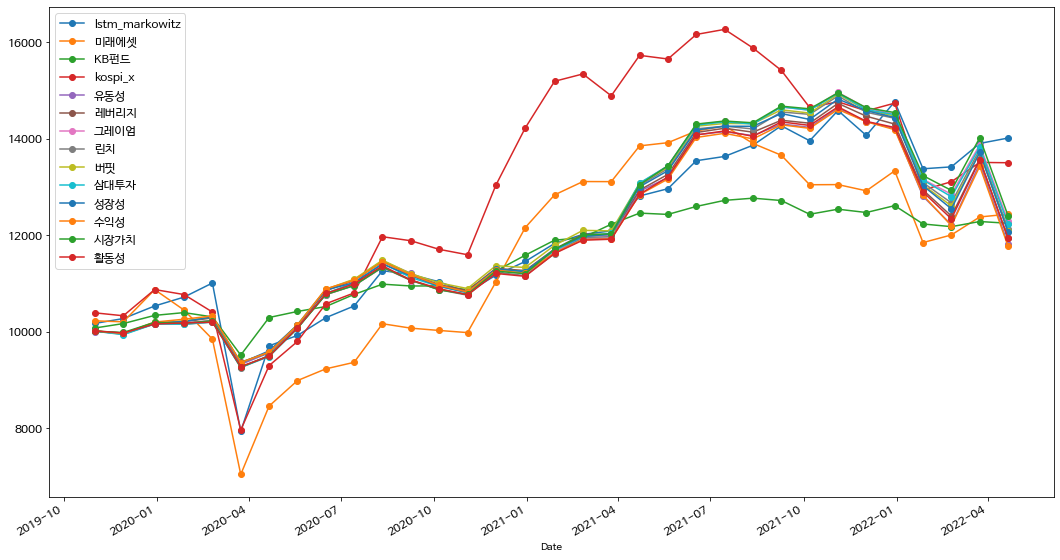

In [ ]:
p = 예측가격[['lstm_markowitz', '미래에셋', 'KB펀드','kospi_x' ,'유동성','레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']].plot(figsize=(18, 10), style = '-o', fontsize=12)
p.legend(fontsize=12)
# plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()

In [ ]:
grp

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

# 주식 전략 결합 중립형

## 중립형

In [ ]:
log_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피
0,2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493,0,1371.589966
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0,1367.699951
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0,1328.949951
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0,1344.760010
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0,1316.670044
...,...,...,...,...,...,...,...,...,...,...
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0,2677.570068
4193,2022-05-05,0.000000,0.000000,0.000000,-0.004196,-0.005292,-0.027030,-0.033019,0,2677.570068
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0,2644.510010
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0,2644.510010


In [ ]:
log_df['Date']=pd.to_datetime(log_df['Date'])

In [ ]:
r_df=pd.read_csv("/content/gdrive/MyDrive/FINAL TEAM/파이널프로젝트/비주식팀/Data/주식전략/로그수익률전체_10종목.csv")

In [ ]:
r_df=r_df.fillna(0)

In [ ]:
r_df.columns

Index(['Unnamed: 0', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법'],
      dtype='object')

In [ ]:
r_df['Unnamed: 0']=pd.to_datetime(r_df['Unnamed: 0'])
r_df.columns=['Date', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']
r_df=r_df.set_index('Date')

In [ ]:
r_df

,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
Date,,,,,,,,,,
2005-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-04-04,-0.001885,-0.003509,0.003417,0.015300,-0.004737,-0.000839,-0.000324,-0.002091,-0.012773,-0.001492
2005-04-06,-0.005572,0.012566,0.005841,-0.002118,0.011094,0.000858,0.002884,0.007565,-0.000898,0.017410
2005-04-07,-0.002721,-0.010705,-0.004159,-0.001387,-0.001534,-0.002636,0.001947,0.000370,0.000927,-0.009234
2005-04-08,-0.002758,-0.003010,-0.001109,-0.000854,0.002285,-0.004228,0.010989,-0.000463,0.009500,0.006397
...,...,...,...,...,...,...,...,...,...,...
2022-05-10,-0.015892,-0.004799,-0.002160,-0.009955,-0.010384,-0.003993,-0.004541,-0.006504,-0.001658,-0.015276
2022-05-11,0.018021,0.000791,-0.003038,0.012060,0.009773,0.009442,0.009268,0.013275,-0.007461,0.018093
2022-05-12,-0.024158,-0.029275,-0.013050,-0.001186,-0.011456,-0.006010,-0.020785,-0.035540,-0.003394,0.005001


In [ ]:
# r_df= r_df.reset_index()
log_df=pd.merge(log_df,r_df, on='Date', how='outer').dropna()

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0.0,1367.699951,-0.004163,0.003148,-0.004245,-0.009235,-0.004180,-0.002885,-0.011703,0.003138,0.001468,0.007272
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0.0,1328.949951,-0.016589,-0.022778,-0.017546,-0.022754,-0.024339,-0.019855,-0.019931,-0.023816,-0.042204,-0.022764
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0.0,1344.760010,0.011637,0.011190,0.004478,0.003144,0.012759,0.010315,0.011755,0.010877,0.021549,0.014470
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0.0,1316.670044,-0.016843,-0.028491,-0.011694,-0.002772,-0.025226,-0.013850,-0.019911,-0.026519,-0.021908,-0.025480
5,2006-03-08,0.000203,0.000818,-0.001992,-0.019625,-0.016154,0.005173,0.007549,0.0,1314.050049,-0.007919,-0.004598,0.010290,0.001887,-0.014189,-0.006048,-0.010333,-0.003670,0.000692,-0.003637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,0.002114,-0.006505,-0.008353,-0.003740,0.001091,-0.004454,-0.004513,-0.006798,-0.001810,-0.008891
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,-0.009320,-0.003745,-0.006407,0.001788,-0.004029,-0.000976,0.000924,-0.002858,0.006830,0.002055
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,0.001078,-0.013734,-0.006216,-0.013486,-0.012977,-0.015054,-0.014405,-0.012405,-0.008364,-0.006202
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,-0.016910,-0.011615,-0.028295,-0.018643,-0.011348,-0.021987,-0.013603,-0.014154,-0.013436,-0.006623


In [ ]:
log_df = log_df.set_index('Date')

## 위험중립형

In [ ]:
극안전형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/극안전형.csv")
안전추구형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/안전추구형.csv")
위험중립형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/위험중립형.csv")
적극투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/적극투자형.csv")
공격투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/공격투자형.csv")

In [ ]:
위험중립형 = 위험중립형[[
 'Unnamed: 0.1',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']]


In [ ]:
# 극안전형.columns=['Date', '단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw',
#        'nsdw']
위험중립형.columns=[ 'Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']
위험중립형.Date=pd.to_datetime(위험중립형.Date)

In [ ]:
위험중립형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.302105,0.316950,0.079802,0.101770,0.059710,0.073006,0.066657
1,2019-11-04,0.316752,0.321605,0.074474,0.105719,0.052982,0.065647,0.062821
2,2019-11-05,0.323645,0.320542,0.069183,0.103440,0.053672,0.066345,0.063173
3,2019-11-06,0.326908,0.328703,0.069171,0.095599,0.055427,0.064947,0.059245
4,2019-11-07,0.330965,0.327891,0.071005,0.090021,0.054892,0.065247,0.059978
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.300370,0.316518,0.061555,0.164353,0.048172,0.053824,0.055208
650,2022-05-05,0.302498,0.321088,0.064784,0.153685,0.048136,0.054207,0.055603
651,2022-05-06,0.335931,0.334951,0.059390,0.112486,0.049278,0.054270,0.053694
652,2022-05-09,0.341899,0.335144,0.066539,0.097209,0.050171,0.055166,0.053872


In [ ]:
log_df=pd.merge(log_df,위험중립형,on='Date',how='inner')

In [ ]:
위험중립형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.302105,0.316950,0.079802,0.101770,0.059710,0.073006,0.066657
1,2019-11-04,0.316752,0.321605,0.074474,0.105719,0.052982,0.065647,0.062821
2,2019-11-05,0.323645,0.320542,0.069183,0.103440,0.053672,0.066345,0.063173
3,2019-11-06,0.326908,0.328703,0.069171,0.095599,0.055427,0.064947,0.059245
4,2019-11-07,0.330965,0.327891,0.071005,0.090021,0.054892,0.065247,0.059978
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.300370,0.316518,0.061555,0.164353,0.048172,0.053824,0.055208
650,2022-05-05,0.302498,0.321088,0.064784,0.153685,0.048136,0.054207,0.055603
651,2022-05-06,0.335931,0.334951,0.059390,0.112486,0.049278,0.054270,0.053694
652,2022-05-09,0.341899,0.335144,0.066539,0.097209,0.050171,0.055166,0.053872


In [ ]:
log_df

,Date,단기채로그_x,중기채로그_x,ksp로그_x,iau로그_x,dbc로그_x,vnq로그_x,nsd로그_x,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채로그_y,중기채로그_y,ksp로그_y,iau로그_y,dbc로그_y,vnq로그_y,nsd로그_y
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.302105,0.316950,0.079802,0.101770,0.059710,0.073006,0.066657
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.316752,0.321605,0.074474,0.105719,0.052982,0.065647,0.062821
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.323645,0.320542,0.069183,0.103440,0.053672,0.066345,0.063173
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.326908,0.328703,0.069171,0.095599,0.055427,0.064947,0.059245
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.330965,0.327891,0.071005,0.090021,0.054892,0.065247,0.059978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.319053,0.324604,0.064418,0.135440,0.048642,0.054000,0.053843
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.300370,0.316518,0.061555,0.164353,0.048172,0.053824,0.055208
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.335931,0.334951,0.059390,0.112486,0.049278,0.054270,0.053694
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.341899,0.335144,0.066539,0.097209,0.050171,0.055166,0.053872


In [ ]:
log_df.columns = ['Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그',
 '상승',
 '코스피',
 '유동성기법',
 '레버리지기법',
 '그레이엄기법',
 '린치기법',
 '버핏기법',
 '삼대투자기법',
 '성장성기법',
 '수익성기법',
 '시장가치기법',
 '활동성기법',
 '단기채w',
 '중기채w',
 'kspw',
 'iauw',
 'dbcw',
 'vnqw',
 'nsdw']

In [ ]:
# log_df = log_df[['Date','단기채로그_y', '중기채로그_y', 'ksp로그_y', 'iau로그_y', 'dbc로그_y', 'vnq로그_y', 'nsd로그_y' ,'상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
#  '성장성기법', '수익성기법', '시장가치기법', '활동성기법' ]]

In [ ]:
# log_df.columns = ['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그', '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법', '성장성기법',
#  '수익성기법', '시장가치기법', '활동성기법']

In [ ]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    623 non-null    datetime64[ns]
 1   단기채로그   623 non-null    float64       
 2   중기채로그   623 non-null    float64       
 3   ksp로그   623 non-null    float64       
 4   iau로그   623 non-null    float64       
 5   dbc로그   623 non-null    float64       
 6   vnq로그   623 non-null    float64       
 7   nsd로그   623 non-null    float64       
 8   상승      623 non-null    float64       
 9   코스피     623 non-null    float64       
 10  유동성기법   623 non-null    float64       
 11  레버리지기법  623 non-null    float64       
 12  그레이엄기법  623 non-null    float64       
 13  린치기법    623 non-null    float64       
 14  버핏기법    623 non-null    float64       
 15  삼대투자기법  623 non-null    float64       
 16  성장성기법   623 non-null    float64       
 17  수익성기법   623 non-null    float64       
 18  시장가치기법  62

In [ ]:
#기간별로 정렬
log_df=log_df.sort_values(by=['Date'], ascending=True)
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.302105,0.316950,0.079802,0.101770,0.059710,0.073006,0.066657
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.316752,0.321605,0.074474,0.105719,0.052982,0.065647,0.062821
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.323645,0.320542,0.069183,0.103440,0.053672,0.066345,0.063173
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.326908,0.328703,0.069171,0.095599,0.055427,0.064947,0.059245
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.330965,0.327891,0.071005,0.090021,0.054892,0.065247,0.059978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.319053,0.324604,0.064418,0.135440,0.048642,0.054000,0.053843
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.300370,0.316518,0.061555,0.164353,0.048172,0.053824,0.055208
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.335931,0.334951,0.059390,0.112486,0.049278,0.054270,0.053694
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.341899,0.335144,0.066539,0.097209,0.050171,0.055166,0.053872


In [ ]:
log_df.index = log_df['Date']


In [ ]:
# 극안전형_df=극안전형_df.fillna(method='ffill').dropna()

In [ ]:
log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]=log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']].cumsum()

In [ ]:
log_df[['유동성w', '레버리지w','그레이엄w', '린치w', '버핏w', '삼대투자w','성장성w', '수익성w', '시장가치w', '활동성w']]=log_df[['유동성기법','레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']].cumsum()

In [ ]:
# log_df[['단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw', 'nsdw','유동성기법', '레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법','성장성기법', '수익성기법', '시장가치기법', '활동성기법'
# ,'단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasd

NameError: ignored

In [ ]:
log_df['금액']=10000

In [ ]:
log_df['kospi']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['ksp로그'])
log_df['유동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['유동성w'])
log_df['레버리지']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['레버리지w'])
log_df['그레이엄']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['그레이엄w'])
log_df['린치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['린치w'])
log_df['버핏']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['버핏w'])
log_df['삼대투자']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['삼대투자w'])
log_df['성장성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['성장성w'])
log_df['수익성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['수익성w'])
log_df['시장가치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['시장가치w'])
log_df['활동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['활동성w'])







In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasdf

NameError: ignored

In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그',
       '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw',
       'dbcw', 'vnqw', 'nsdw', '유동성w', '레버리지w', '그레이엄w', '린치w', '버핏w', '삼대투자w',
       '성장성w', '수익성w', '시장가치w', '활동성w', '금액', 'kospi', '유동성', '레버리지', '그레이엄',
       '린치', '버핏', '삼대투자', '성장성', '수익성', '시장가치', '활동성'],
      dtype='object')

In [ ]:
grp

,lstm_markowitz,kospi,미래에셋,KB펀드
Date,,,,
2019-10-04,10000.000000,10000.000000,10000.000000,10000.000000
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894


In [ ]:
log_df


,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,10006.484295,10018.023466,10013.713886,10010.613170,10015.817953,10012.487512,10012.748429,10016.977629,10012.849538,10017.685513
2019-11-04,2019-11-04,0.000168,-0.002161,0.022195,-0.002077,0.024486,-0.007237,-0.011898,0.0,2130.239990,...,10003.289378,10005.536726,9999.613051,10002.691253,10000.591475,10004.743906,10009.164922,10008.744221,10005.036598,10017.561570
2019-11-05,2019-11-05,0.000232,-0.001148,0.027999,-0.018849,0.027029,-0.024367,-0.013624,0.0,2142.639893,...,9988.428779,9979.810286,9975.168031,9980.242103,9978.273535,9977.894285,9986.484792,9988.050551,9987.204973,9994.806302
2019-11-06,2019-11-06,0.000255,-0.001098,0.028704,-0.013928,0.016176,-0.022196,0.001502,0.0,2144.149902,...,9999.354496,9988.170076,9984.078305,9992.285945,9984.664875,9985.660533,10008.196658,9992.435626,10000.385743,10004.307467
2019-11-07,2019-11-07,0.000278,-0.001796,0.028769,-0.030188,0.015534,-0.032221,0.007589,0.0,2144.290039,...,9981.995477,9970.159885,9963.985928,9975.152421,9969.452769,9970.709848,9986.447802,9974.246643,9985.809000,9991.631383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,2022-05-03,0.028070,-0.002431,0.251949,0.144817,0.652885,0.173650,0.408839,0.0,2680.459961,...,11019.480315,11115.769262,11404.688298,11270.534662,11251.497757,11366.660445,11224.085288,10986.455748,11496.147790,11138.847941
2022-05-04,2022-05-04,0.028154,-0.003295,0.250870,0.154636,0.683612,0.185075,0.423056,0.0,2677.570068,...,11125.515078,11220.077151,11492.763368,11371.628357,11349.077890,11461.282609,11326.542409,11097.407360,11592.554660,11245.739523
2022-05-06,2022-05-06,0.028263,-0.002294,0.238446,0.156597,0.684673,0.173135,0.406062,0.0,2644.510010,...,11041.842599,11124.476184,11390.340741,11268.882570,11247.776276,11352.951081,11225.336150,11008.355848,11483.998127,11153.490788


In [ ]:
log_df =log_df.drop('Date',axis=1)

In [ ]:
# grp = grp.drop(['level_0', 'index'], axis=1)

In [ ]:
예측가격 = pd.merge(grp,log_df[['kospi','유동성', '레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']],on='Date',how='outer').dropna()

In [ ]:
예측가격

,lstm_markowitz,kospi_x,미래에셋,KB펀드,kospi_y,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967,10012.763375,10006.484295,10018.023466,10013.713886,10010.613170,10015.817953,10012.487512,10012.748429,10016.977629,10012.849538,10017.685513
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403,9991.702138,9987.991551,9975.872501,9986.231429,9988.999786,9985.009659,9968.157137,9998.529018,9990.207757,10008.968839,9999.936505
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641,10149.032524,10128.642509,10130.681937,10160.802678,10142.215730,10145.580063,10125.116939,10141.185626,10161.047679,10156.826242,10125.054084
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566,10190.185879,10148.229109,10180.142514,10160.319031,10130.080685,10195.661703,10133.639989,10186.033606,10228.116799,10150.460303,10157.283939
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928,10202.380296,10157.729978,10203.388045,10145.539920,10131.909874,10220.921484,10125.425689,10218.541246,10239.358864,10151.905722,10123.766872
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916,9500.794045,9505.431196,9547.400939,9450.143290,9446.584823,9537.670451,9451.496148,9528.174555,9539.277313,9456.951859,9466.665821
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866,10048.702493,10105.235532,10110.735912,10044.890652,10039.080650,10122.477538,10022.018819,10149.714572,10122.699608,10041.477631,10030.502424
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894,10488.481810,10540.226006,10567.093418,10498.063377,10497.221872,10589.965724,10482.077033,10578.716693,10570.237584,10484.448285,10496.149434
2020-06-16,10293.127910,10580.792258,9233.720150,10523.844793,10689.032391,10770.660696,10732.848660,10606.136258,10610.571875,10778.179742,10644.894940,10759.852785,10793.956326,10616.805361,10649.147232


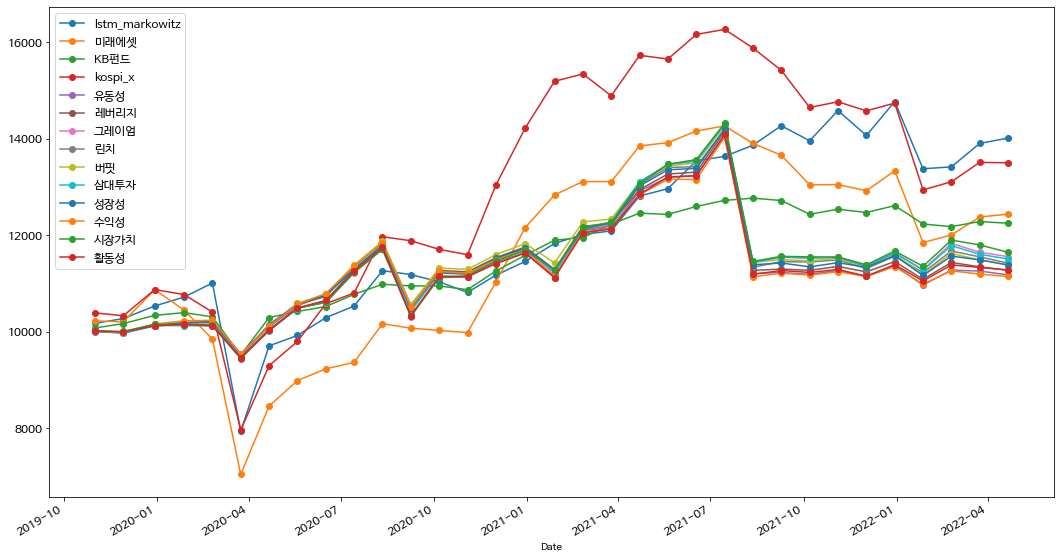

In [ ]:
p = 예측가격[['lstm_markowitz', '미래에셋', 'KB펀드','kospi_x' ,'유동성','레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']].plot(figsize=(18, 10), style = '-o', fontsize=12)
p.legend(fontsize=12)
# plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()

In [ ]:
grp

# 주식 전략 결합 적극투자형

## 적극투자형

In [ ]:
log_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피
0,2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493,0,1371.589966
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0,1367.699951
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0,1328.949951
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0,1344.760010
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0,1316.670044
...,...,...,...,...,...,...,...,...,...,...
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0,2677.570068
4193,2022-05-05,0.000000,0.000000,0.000000,-0.004196,-0.005292,-0.027030,-0.033019,0,2677.570068
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0,2644.510010
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0,2644.510010


In [ ]:
log_df['Date']=pd.to_datetime(log_df['Date'])

In [ ]:
r_df=pd.read_csv("/content/gdrive/MyDrive/FINAL TEAM/파이널프로젝트/비주식팀/Data/주식전략/로그수익률전체_10종목.csv")

In [ ]:
r_df=r_df.fillna(0)

In [ ]:
r_df.columns

Index(['Unnamed: 0', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법'],
      dtype='object')

In [ ]:
r_df['Unnamed: 0']=pd.to_datetime(r_df['Unnamed: 0'])
r_df.columns=['Date', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']
r_df=r_df.set_index('Date')

In [ ]:
r_df

,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
Date,,,,,,,,,,
2005-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-04-04,-0.001885,-0.003509,0.003417,0.015300,-0.004737,-0.000839,-0.000324,-0.002091,-0.012773,-0.001492
2005-04-06,-0.005572,0.012566,0.005841,-0.002118,0.011094,0.000858,0.002884,0.007565,-0.000898,0.017410
2005-04-07,-0.002721,-0.010705,-0.004159,-0.001387,-0.001534,-0.002636,0.001947,0.000370,0.000927,-0.009234
2005-04-08,-0.002758,-0.003010,-0.001109,-0.000854,0.002285,-0.004228,0.010989,-0.000463,0.009500,0.006397
...,...,...,...,...,...,...,...,...,...,...
2022-05-10,-0.015892,-0.004799,-0.002160,-0.009955,-0.010384,-0.003993,-0.004541,-0.006504,-0.001658,-0.015276
2022-05-11,0.018021,0.000791,-0.003038,0.012060,0.009773,0.009442,0.009268,0.013275,-0.007461,0.018093
2022-05-12,-0.024158,-0.029275,-0.013050,-0.001186,-0.011456,-0.006010,-0.020785,-0.035540,-0.003394,0.005001


In [ ]:
# r_df= r_df.reset_index()
log_df=pd.merge(log_df,r_df, on='Date', how='outer').dropna()

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0.0,1367.699951,-0.004163,0.003148,-0.004245,-0.009235,-0.004180,-0.002885,-0.011703,0.003138,0.001468,0.007272
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0.0,1328.949951,-0.016589,-0.022778,-0.017546,-0.022754,-0.024339,-0.019855,-0.019931,-0.023816,-0.042204,-0.022764
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0.0,1344.760010,0.011637,0.011190,0.004478,0.003144,0.012759,0.010315,0.011755,0.010877,0.021549,0.014470
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0.0,1316.670044,-0.016843,-0.028491,-0.011694,-0.002772,-0.025226,-0.013850,-0.019911,-0.026519,-0.021908,-0.025480
5,2006-03-08,0.000203,0.000818,-0.001992,-0.019625,-0.016154,0.005173,0.007549,0.0,1314.050049,-0.007919,-0.004598,0.010290,0.001887,-0.014189,-0.006048,-0.010333,-0.003670,0.000692,-0.003637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,0.002114,-0.006505,-0.008353,-0.003740,0.001091,-0.004454,-0.004513,-0.006798,-0.001810,-0.008891
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,-0.009320,-0.003745,-0.006407,0.001788,-0.004029,-0.000976,0.000924,-0.002858,0.006830,0.002055
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,0.001078,-0.013734,-0.006216,-0.013486,-0.012977,-0.015054,-0.014405,-0.012405,-0.008364,-0.006202
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,-0.016910,-0.011615,-0.028295,-0.018643,-0.011348,-0.021987,-0.013603,-0.014154,-0.013436,-0.006623


In [ ]:
log_df = log_df.set_index('Date')

## 적극투자형

In [ ]:
극안전형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/극안전형.csv")
안전추구형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/안전추구형.csv")
위험중립형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/위험중립형.csv")
적극투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/적극투자형.csv")
공격투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/공격투자형.csv")

In [ ]:
적극투자형 = 적극투자형[[
 'Unnamed: 0.1',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']]


In [ ]:
# 극안전형.columns=['Date', '단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw',
#        'nsdw']
적극투자형.columns=[ 'Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']
적극투자형.Date=pd.to_datetime(적극투자형.Date)

In [ ]:
적극투자형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.253146,0.306524,0.086440,0.119286,0.066213,0.089295,0.079097
1,2019-11-04,0.282730,0.310174,0.078695,0.120887,0.056160,0.077087,0.074267
2,2019-11-05,0.296754,0.307401,0.073948,0.111087,0.057821,0.079220,0.073769
3,2019-11-06,0.302924,0.319697,0.074628,0.098189,0.061355,0.077226,0.065981
4,2019-11-07,0.310493,0.315370,0.076878,0.091894,0.060454,0.077488,0.067423
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.087525,0.142383,0.072486,0.290586,0.052202,0.106591,0.248228
650,2022-05-05,0.111022,0.180484,0.075093,0.248532,0.055280,0.111053,0.218536
651,2022-05-06,0.258355,0.251454,0.066819,0.167581,0.059652,0.087023,0.109115
652,2022-05-09,0.264171,0.238011,0.073027,0.157847,0.064440,0.092907,0.109598


In [ ]:
log_df=pd.merge(log_df,적극투자형,on='Date',how='inner')

In [ ]:
적극투자형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.253146,0.306524,0.086440,0.119286,0.066213,0.089295,0.079097
1,2019-11-04,0.282730,0.310174,0.078695,0.120887,0.056160,0.077087,0.074267
2,2019-11-05,0.296754,0.307401,0.073948,0.111087,0.057821,0.079220,0.073769
3,2019-11-06,0.302924,0.319697,0.074628,0.098189,0.061355,0.077226,0.065981
4,2019-11-07,0.310493,0.315370,0.076878,0.091894,0.060454,0.077488,0.067423
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.087525,0.142383,0.072486,0.290586,0.052202,0.106591,0.248228
650,2022-05-05,0.111022,0.180484,0.075093,0.248532,0.055280,0.111053,0.218536
651,2022-05-06,0.258355,0.251454,0.066819,0.167581,0.059652,0.087023,0.109115
652,2022-05-09,0.264171,0.238011,0.073027,0.157847,0.064440,0.092907,0.109598


In [ ]:
log_df

,Date,단기채로그_x,중기채로그_x,ksp로그_x,iau로그_x,dbc로그_x,vnq로그_x,nsd로그_x,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채로그_y,중기채로그_y,ksp로그_y,iau로그_y,dbc로그_y,vnq로그_y,nsd로그_y
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.253146,0.306524,0.086440,0.119286,0.066213,0.089295,0.079097
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.282730,0.310174,0.078695,0.120887,0.056160,0.077087,0.074267
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.296754,0.307401,0.073948,0.111087,0.057821,0.079220,0.073769
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.302924,0.319697,0.074628,0.098189,0.061355,0.077226,0.065981
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.310493,0.315370,0.076878,0.091894,0.060454,0.077488,0.067423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.211209,0.212748,0.072154,0.218198,0.059684,0.090479,0.135528
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.087525,0.142383,0.072486,0.290586,0.052202,0.106591,0.248228
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.258355,0.251454,0.066819,0.167581,0.059652,0.087023,0.109115
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.264171,0.238011,0.073027,0.157847,0.064440,0.092907,0.109598


In [ ]:
log_df.columns = ['Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그',
 '상승',
 '코스피',
 '유동성기법',
 '레버리지기법',
 '그레이엄기법',
 '린치기법',
 '버핏기법',
 '삼대투자기법',
 '성장성기법',
 '수익성기법',
 '시장가치기법',
 '활동성기법',
 '단기채w',
 '중기채w',
 'kspw',
 'iauw',
 'dbcw',
 'vnqw',
 'nsdw']

In [ ]:
# log_df = log_df[['Date','단기채로그_y', '중기채로그_y', 'ksp로그_y', 'iau로그_y', 'dbc로그_y', 'vnq로그_y', 'nsd로그_y' ,'상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
#  '성장성기법', '수익성기법', '시장가치기법', '활동성기법' ]]

In [ ]:
# log_df.columns = ['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그', '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법', '성장성기법',
#  '수익성기법', '시장가치기법', '활동성기법']

In [ ]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    623 non-null    datetime64[ns]
 1   단기채로그   623 non-null    float64       
 2   중기채로그   623 non-null    float64       
 3   ksp로그   623 non-null    float64       
 4   iau로그   623 non-null    float64       
 5   dbc로그   623 non-null    float64       
 6   vnq로그   623 non-null    float64       
 7   nsd로그   623 non-null    float64       
 8   상승      623 non-null    float64       
 9   코스피     623 non-null    float64       
 10  유동성기법   623 non-null    float64       
 11  레버리지기법  623 non-null    float64       
 12  그레이엄기법  623 non-null    float64       
 13  린치기법    623 non-null    float64       
 14  버핏기법    623 non-null    float64       
 15  삼대투자기법  623 non-null    float64       
 16  성장성기법   623 non-null    float64       
 17  수익성기법   623 non-null    float64       
 18  시장가치기법  62

In [ ]:
#기간별로 정렬
log_df=log_df.sort_values(by=['Date'], ascending=True)
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.253146,0.306524,0.086440,0.119286,0.066213,0.089295,0.079097
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.282730,0.310174,0.078695,0.120887,0.056160,0.077087,0.074267
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.296754,0.307401,0.073948,0.111087,0.057821,0.079220,0.073769
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.302924,0.319697,0.074628,0.098189,0.061355,0.077226,0.065981
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.310493,0.315370,0.076878,0.091894,0.060454,0.077488,0.067423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.211209,0.212748,0.072154,0.218198,0.059684,0.090479,0.135528
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.087525,0.142383,0.072486,0.290586,0.052202,0.106591,0.248228
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.258355,0.251454,0.066819,0.167581,0.059652,0.087023,0.109115
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.264171,0.238011,0.073027,0.157847,0.064440,0.092907,0.109598


In [ ]:
log_df.index = log_df['Date']


In [ ]:
# 극안전형_df=극안전형_df.fillna(method='ffill').dropna()

In [ ]:
log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]=log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']].cumsum()

In [ ]:
log_df[['유동성w', '레버리지w','그레이엄w', '린치w', '버핏w', '삼대투자w','성장성w', '수익성w', '시장가치w', '활동성w']]=log_df[['유동성기법','레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']].cumsum()

In [ ]:
# log_df[['단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw', 'nsdw','유동성기법', '레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법','성장성기법', '수익성기법', '시장가치기법', '활동성기법'
# ,'단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasd

NameError: ignored

In [ ]:
log_df['금액']=10000

In [ ]:
log_df['kospi']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['ksp로그'])
log_df['유동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['유동성w'])
log_df['레버리지']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['레버리지w'])
log_df['그레이엄']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['그레이엄w'])
log_df['린치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['린치w'])
log_df['버핏']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['버핏w'])
log_df['삼대투자']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['삼대투자w'])
log_df['성장성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['성장성w'])
log_df['수익성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['수익성w'])
log_df['시장가치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['시장가치w'])
log_df['활동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['활동성w'])







In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasdf

NameError: ignored

In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그',
       '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw',
       'dbcw', 'vnqw', 'nsdw', '유동성w', '레버리지w', '그레이엄w', '린치w', '버핏w', '삼대투자w',
       '성장성w', '수익성w', '시장가치w', '활동성w', '금액', 'kospi', '유동성', '레버리지', '그레이엄',
       '린치', '버핏', '삼대투자', '성장성', '수익성', '시장가치', '활동성'],
      dtype='object')

In [ ]:
grp

,lstm_markowitz,kospi,미래에셋,KB펀드
Date,,,,
2019-10-04,10000.000000,10000.000000,10000.000000,10000.000000
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894


In [ ]:
log_df


,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,10006.983631,10019.482760,10014.814661,10011.455992,10017.093768,10013.486263,10013.768886,10018.349919,10013.878407,10019.116693
2019-11-04,2019-11-04,0.000168,-0.002161,0.022195,-0.002077,0.024486,-0.007237,-0.011898,0.0,2130.239990,...,10002.393887,10004.768605,9998.509202,10001.761863,9999.543078,10003.930852,10008.602433,10008.157889,10004.240132,10017.474968
2019-11-05,2019-11-05,0.000232,-0.001148,0.027999,-0.018849,0.027029,-0.024367,-0.013624,0.0,2142.639893,...,9985.104032,9975.891966,9970.929990,9976.353523,9974.249376,9973.844006,9983.026159,9984.699754,9983.795940,9991.920787
2019-11-06,2019-11-06,0.000255,-0.001098,0.028704,-0.013928,0.016176,-0.022196,0.001502,0.0,2144.149902,...,9998.956801,9986.890155,9982.475626,9991.330684,9983.108465,9984.182660,10008.496432,9991.492172,10000.069393,10004.300462
2019-11-07,2019-11-07,0.000278,-0.001796,0.028769,-0.030188,0.015534,-0.032221,0.007589,0.0,2144.290039,...,9980.921105,9968.106542,9961.421911,9973.512031,9967.340938,9968.701995,9985.741700,9972.531332,9985.050060,9991.354036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,2022-05-03,0.028070,-0.002431,0.251949,0.144817,0.652885,0.173650,0.408839,0.0,2680.459961,...,11692.273238,11800.124936,12123.738495,11973.475168,11952.152238,12081.144110,11921.447972,11655.282951,12226.180799,11825.974992
2022-05-04,2022-05-04,0.028154,-0.003295,0.250870,0.154636,0.683612,0.185075,0.423056,0.0,2677.570068,...,12427.556738,12538.910774,12860.019541,12717.373849,12690.818959,12822.948552,12664.281716,12394.457762,12977.531380,12569.130170
2022-05-06,2022-05-06,0.028263,-0.002294,0.238446,0.156597,0.684673,0.173135,0.406062,0.0,2644.510010,...,11544.732058,11637.701792,11936.821783,11800.171124,11776.424768,11894.755271,11751.177739,11507.056646,12042.194221,11670.345663


In [ ]:
log_df =log_df.drop('Date',axis=1)

In [ ]:
# grp = grp.drop(['level_0', 'index'], axis=1)

In [ ]:
예측가격 = pd.merge(grp,log_df[['kospi','유동성', '레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']],on='Date',how='outer').dropna()

In [ ]:
예측가격

,lstm_markowitz,kospi_x,미래에셋,KB펀드,kospi_y,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967,10013.785075,10006.983631,10019.482760,10014.814661,10011.455992,10017.093768,10013.486263,10013.768886,10018.349919,10013.878407,10019.116693
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403,9976.412374,9972.425313,9959.403277,9970.534045,9973.508671,9969.221242,9951.113043,9983.747923,9974.806647,9994.965612,9985.260281
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641,10163.758005,10142.144414,10144.306225,10176.234468,10156.532145,10160.098367,10138.407280,10155.440225,10176.494171,10172.019412,10138.340653
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566,10202.243382,10158.064754,10191.668162,10170.794909,10138.955265,10208.009183,10142.703055,10197.871222,10242.182966,10160.414104,10167.599091
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928,10212.717810,10165.736759,10213.778163,10152.910384,10138.568855,10232.226842,10131.746196,10229.722357,10251.626647,10159.608479,10130.000790
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916,9433.949848,9438.850787,9483.208016,9380.417781,9376.656888,9472.924000,9381.847598,9462.887922,9474.622270,9387.613662,9397.880210
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866,9855.877257,9906.116501,9911.004527,9852.489787,9847.326609,9921.438964,9832.164263,9945.643712,9921.636311,9849.456735,9839.703393
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894,10311.002282,10351.800827,10372.984872,10318.557023,10317.893525,10391.018910,10305.952333,10382.149430,10375.463940,10307.821985,10317.047945
2020-06-16,10293.127910,10580.792258,9233.720150,10523.844793,10940.189672,11000.706080,10972.673542,10878.733340,10882.021753,11006.280441,10907.467689,10992.693468,11017.976656,10886.643045,10910.620191


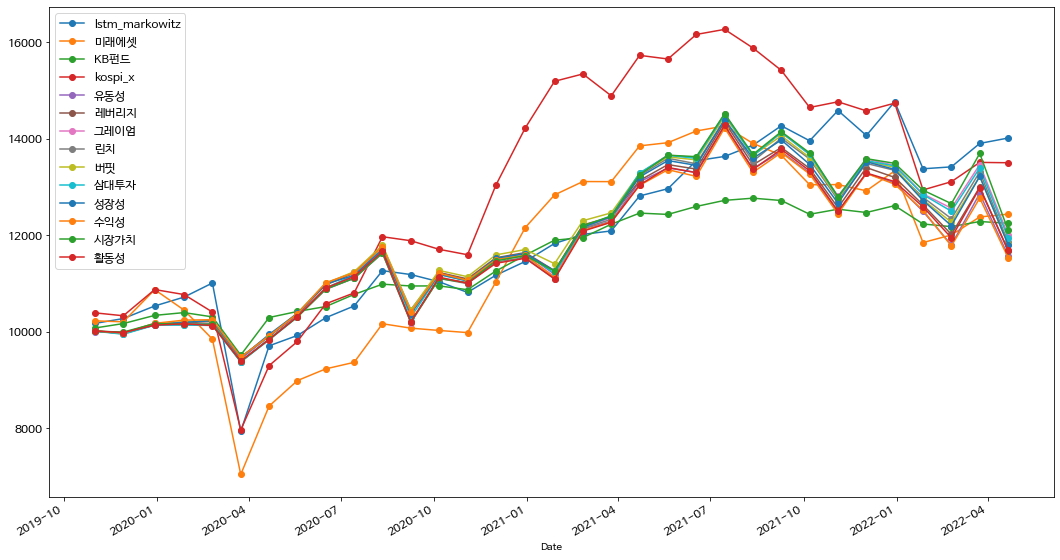

In [ ]:
p = 예측가격[['lstm_markowitz', '미래에셋', 'KB펀드','kospi_x' ,'유동성','레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']].plot(figsize=(18, 10), style = '-o', fontsize=12)
p.legend(fontsize=12)
# plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()

In [ ]:
grp

# 주식 전략 결합 안전추구형

## 안전추구형

In [ ]:
log_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피
0,2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493,0,1371.589966
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0,1367.699951
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0,1328.949951
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0,1344.760010
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0,1316.670044
...,...,...,...,...,...,...,...,...,...,...
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0,2677.570068
4193,2022-05-05,0.000000,0.000000,0.000000,-0.004196,-0.005292,-0.027030,-0.033019,0,2677.570068
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0,2644.510010
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0,2644.510010


In [ ]:
log_df['Date']=pd.to_datetime(log_df['Date'])

In [ ]:
r_df=pd.read_csv("/content/gdrive/MyDrive/FINAL TEAM/파이널프로젝트/비주식팀/Data/주식전략/로그수익률전체_10종목.csv")

In [ ]:
r_df=r_df.fillna(0)

In [ ]:
r_df.columns

Index(['Unnamed: 0', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법'],
      dtype='object')

In [ ]:
r_df['Unnamed: 0']=pd.to_datetime(r_df['Unnamed: 0'])
r_df.columns=['Date', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']
r_df=r_df.set_index('Date')

In [ ]:
r_df

,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
Date,,,,,,,,,,
2005-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-04-04,-0.001885,-0.003509,0.003417,0.015300,-0.004737,-0.000839,-0.000324,-0.002091,-0.012773,-0.001492
2005-04-06,-0.005572,0.012566,0.005841,-0.002118,0.011094,0.000858,0.002884,0.007565,-0.000898,0.017410
2005-04-07,-0.002721,-0.010705,-0.004159,-0.001387,-0.001534,-0.002636,0.001947,0.000370,0.000927,-0.009234
2005-04-08,-0.002758,-0.003010,-0.001109,-0.000854,0.002285,-0.004228,0.010989,-0.000463,0.009500,0.006397
...,...,...,...,...,...,...,...,...,...,...
2022-05-10,-0.015892,-0.004799,-0.002160,-0.009955,-0.010384,-0.003993,-0.004541,-0.006504,-0.001658,-0.015276
2022-05-11,0.018021,0.000791,-0.003038,0.012060,0.009773,0.009442,0.009268,0.013275,-0.007461,0.018093
2022-05-12,-0.024158,-0.029275,-0.013050,-0.001186,-0.011456,-0.006010,-0.020785,-0.035540,-0.003394,0.005001


In [ ]:
# r_df= r_df.reset_index()
log_df=pd.merge(log_df,r_df, on='Date', how='outer').dropna()

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0.0,1367.699951,-0.004163,0.003148,-0.004245,-0.009235,-0.004180,-0.002885,-0.011703,0.003138,0.001468,0.007272
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0.0,1328.949951,-0.016589,-0.022778,-0.017546,-0.022754,-0.024339,-0.019855,-0.019931,-0.023816,-0.042204,-0.022764
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0.0,1344.760010,0.011637,0.011190,0.004478,0.003144,0.012759,0.010315,0.011755,0.010877,0.021549,0.014470
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0.0,1316.670044,-0.016843,-0.028491,-0.011694,-0.002772,-0.025226,-0.013850,-0.019911,-0.026519,-0.021908,-0.025480
5,2006-03-08,0.000203,0.000818,-0.001992,-0.019625,-0.016154,0.005173,0.007549,0.0,1314.050049,-0.007919,-0.004598,0.010290,0.001887,-0.014189,-0.006048,-0.010333,-0.003670,0.000692,-0.003637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,0.002114,-0.006505,-0.008353,-0.003740,0.001091,-0.004454,-0.004513,-0.006798,-0.001810,-0.008891
4192,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,-0.009320,-0.003745,-0.006407,0.001788,-0.004029,-0.000976,0.000924,-0.002858,0.006830,0.002055
4194,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,0.001078,-0.013734,-0.006216,-0.013486,-0.012977,-0.015054,-0.014405,-0.012405,-0.008364,-0.006202
4195,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,-0.016910,-0.011615,-0.028295,-0.018643,-0.011348,-0.021987,-0.013603,-0.014154,-0.013436,-0.006623


In [ ]:
log_df = log_df.set_index('Date')

## 안전추구형

In [ ]:
극안전형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/극안전형.csv")
안전추구형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/안전추구형.csv")
위험중립형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/위험중립형.csv")
적극투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/적극투자형.csv")
공격투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/공격투자형.csv")

In [ ]:
안전추구형 = 안전추구형[[
 'Unnamed: 0.1',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']]


In [ ]:
# 극안전형.columns=['Date', '단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw',
#        'nsdw']
안전추구형.columns=[ 'Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그']
안전추구형.Date=pd.to_datetime(안전추구형.Date)

In [ ]:
안전추구형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.334384,0.329883,0.071644,0.091448,0.053930,0.060548,0.058163
1,2019-11-04,0.338141,0.333026,0.069309,0.095266,0.050821,0.057407,0.056030
2,2019-11-05,0.339822,0.331417,0.064927,0.098750,0.050966,0.057494,0.056624
3,2019-11-06,0.341990,0.335656,0.064525,0.094526,0.051688,0.056699,0.054916
4,2019-11-07,0.343573,0.336916,0.065988,0.089939,0.051494,0.056912,0.055176
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.222588,0.299247,0.069188,0.201980,0.054890,0.074083,0.078025
650,2022-05-05,0.237079,0.301805,0.072054,0.181252,0.053988,0.073955,0.079868
651,2022-05-06,0.314017,0.319940,0.063591,0.110078,0.054270,0.070922,0.067181
652,2022-05-09,0.321980,0.311308,0.070837,0.099521,0.056399,0.072441,0.067515


In [ ]:
log_df=pd.merge(log_df,안전추구형,on='Date',how='inner')

In [ ]:
안전추구형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.334384,0.329883,0.071644,0.091448,0.053930,0.060548,0.058163
1,2019-11-04,0.338141,0.333026,0.069309,0.095266,0.050821,0.057407,0.056030
2,2019-11-05,0.339822,0.331417,0.064927,0.098750,0.050966,0.057494,0.056624
3,2019-11-06,0.341990,0.335656,0.064525,0.094526,0.051688,0.056699,0.054916
4,2019-11-07,0.343573,0.336916,0.065988,0.089939,0.051494,0.056912,0.055176
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.222588,0.299247,0.069188,0.201980,0.054890,0.074083,0.078025
650,2022-05-05,0.237079,0.301805,0.072054,0.181252,0.053988,0.073955,0.079868
651,2022-05-06,0.314017,0.319940,0.063591,0.110078,0.054270,0.070922,0.067181
652,2022-05-09,0.321980,0.311308,0.070837,0.099521,0.056399,0.072441,0.067515


In [ ]:
log_df

,Date,단기채로그_x,중기채로그_x,ksp로그_x,iau로그_x,dbc로그_x,vnq로그_x,nsd로그_x,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채로그_y,중기채로그_y,ksp로그_y,iau로그_y,dbc로그_y,vnq로그_y,nsd로그_y
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.334384,0.329883,0.071644,0.091448,0.053930,0.060548,0.058163
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.338141,0.333026,0.069309,0.095266,0.050821,0.057407,0.056030
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.339822,0.331417,0.064927,0.098750,0.050966,0.057494,0.056624
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.341990,0.335656,0.064525,0.094526,0.051688,0.056699,0.054916
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.343573,0.336916,0.065988,0.089939,0.051494,0.056912,0.055176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.313216,0.313237,0.067281,0.121166,0.053423,0.066749,0.064928
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.222588,0.299247,0.069188,0.201980,0.054890,0.074083,0.078025
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.314017,0.319940,0.063591,0.110078,0.054270,0.070922,0.067181
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.321980,0.311308,0.070837,0.099521,0.056399,0.072441,0.067515


In [ ]:
log_df.columns = ['Date',
 '단기채로그',
 '중기채로그',
 'ksp로그',
 'iau로그',
 'dbc로그',
 'vnq로그',
 'nsd로그',
 '상승',
 '코스피',
 '유동성기법',
 '레버리지기법',
 '그레이엄기법',
 '린치기법',
 '버핏기법',
 '삼대투자기법',
 '성장성기법',
 '수익성기법',
 '시장가치기법',
 '활동성기법',
 '단기채w',
 '중기채w',
 'kspw',
 'iauw',
 'dbcw',
 'vnqw',
 'nsdw']

In [ ]:
# log_df = log_df[['Date','단기채로그_y', '중기채로그_y', 'ksp로그_y', 'iau로그_y', 'dbc로그_y', 'vnq로그_y', 'nsd로그_y' ,'상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
#  '성장성기법', '수익성기법', '시장가치기법', '활동성기법' ]]

In [ ]:
# log_df.columns = ['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그', '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법', '성장성기법',
#  '수익성기법', '시장가치기법', '활동성기법']

In [ ]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    623 non-null    datetime64[ns]
 1   단기채로그   623 non-null    float64       
 2   중기채로그   623 non-null    float64       
 3   ksp로그   623 non-null    float64       
 4   iau로그   623 non-null    float64       
 5   dbc로그   623 non-null    float64       
 6   vnq로그   623 non-null    float64       
 7   nsd로그   623 non-null    float64       
 8   상승      623 non-null    float64       
 9   코스피     623 non-null    float64       
 10  유동성기법   623 non-null    float64       
 11  레버리지기법  623 non-null    float64       
 12  그레이엄기법  623 non-null    float64       
 13  린치기법    623 non-null    float64       
 14  버핏기법    623 non-null    float64       
 15  삼대투자기법  623 non-null    float64       
 16  성장성기법   623 non-null    float64       
 17  수익성기법   623 non-null    float64       
 18  시장가치기법  62

In [ ]:
#기간별로 정렬
log_df=log_df.sort_values(by=['Date'], ascending=True)
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,수익성기법,시장가치기법,활동성기법,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw
0,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.013218,0.008100,0.014093,0.334384,0.329883,0.071644,0.091448,0.053930,0.060548,0.058163
1,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008534,0.008769,0.019177,0.338141,0.333026,0.069309,0.095266,0.050821,0.057407,0.056030
2,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.006894,0.010589,0.004821,0.339822,0.331417,0.064927,0.098750,0.050966,0.057494,0.056624
3,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,-0.010374,0.002037,-0.003107,0.341990,0.335656,0.064525,0.094526,0.051688,0.056699,0.054916
4,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.000568,0.005200,0.007599,0.343573,0.336916,0.065988,0.089939,0.051494,0.056912,0.055176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.006798,-0.001810,-0.008891,0.313216,0.313237,0.067281,0.121166,0.053423,0.066749,0.064928
619,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,-0.002858,0.006830,0.002055,0.222588,0.299247,0.069188,0.201980,0.054890,0.074083,0.078025
620,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.012405,-0.008364,-0.006202,0.314017,0.319940,0.063591,0.110078,0.054270,0.070922,0.067181
621,2022-05-09,0.000202,0.002147,0.000000,-0.014940,-0.046284,-0.045043,-0.040948,0.0,2644.510010,...,-0.014154,-0.013436,-0.006623,0.321980,0.311308,0.070837,0.099521,0.056399,0.072441,0.067515


In [ ]:
log_df.index = log_df['Date']


In [ ]:
# log_df.isna().sum()

In [ ]:
# log_df=극안전형_df.fillna(method='ffill').dropna()

In [ ]:
log_df['금액']=10000

In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,시장가치기법,활동성기법,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw,금액
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.008100,0.014093,0.334384,0.329883,0.071644,0.091448,0.053930,0.060548,0.058163,10000
2019-11-04,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.008769,0.019177,0.338141,0.333026,0.069309,0.095266,0.050821,0.057407,0.056030,10000
2019-11-05,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.010589,0.004821,0.339822,0.331417,0.064927,0.098750,0.050966,0.057494,0.056624,10000
2019-11-06,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,0.002037,-0.003107,0.341990,0.335656,0.064525,0.094526,0.051688,0.056699,0.054916,10000
2019-11-07,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.005200,0.007599,0.343573,0.336916,0.065988,0.089939,0.051494,0.056912,0.055176,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,-0.001810,-0.008891,0.313216,0.313237,0.067281,0.121166,0.053423,0.066749,0.064928,10000
2022-05-04,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,0.006830,0.002055,0.222588,0.299247,0.069188,0.201980,0.054890,0.074083,0.078025,10000
2022-05-06,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,-0.008364,-0.006202,0.314017,0.319940,0.063591,0.110078,0.054270,0.070922,0.067181,10000


# check

In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그',
       '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw',
       'dbcw', 'vnqw', 'nsdw', '금액', 'kospi', '유동성추이'],
      dtype='object')

In [ ]:
log_df['유동성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['유동성'])
log_df['레버리지추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['레버리지'])
log_df['그레이엄추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['그레이엄'])
log_df['린치추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['린치'])
log_df['버핏추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['버핏'])
log_df['삼대투자추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['삼대투자'])
log_df['성장성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['성장성'])
log_df['수익성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['수익성'])
log_df['시장가치추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['시장가치'])
log_df['활동성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['활동성'])






In [ ]:
log_df['kospi']=10000
log_df['유동성추이']=10000

In [ ]:
for i in range(1,623):
    log_df['kospi'].iloc[i]=(log_df['kospi'].iloc[i-1]*log_df['단기채w'].iloc[i]+10000*log_df['단기채w'].iloc[i]*0.00012)+(log_df['kospi'].iloc[i-1]*log_df['중기채w'].iloc[i]+10000*log_df['중기채w'].iloc[i]*0.0002172)+log_df['kospi'].iloc[i-1]*log_df['iauw'].iloc[i]*np.exp(log_df['iau로그'].iloc[i])+log_df['kospi'].iloc[i-1]*log_df['dbcw'].iloc[i]*np.exp(log_df['dbc로그'].iloc[i])+log_df['kospi'].iloc[i-1]*log_df['vnqw'].iloc[i]*np.exp(log_df['vnq로그'].iloc[i])+log_df['kospi'].iloc[i-1]*log_df['nsdw'].iloc[i]*np.exp(log_df['nsd로그'].iloc[i])+log_df['kospi'].iloc[i-1]*log_df['kspw'].iloc[i]*np.exp(log_df['ksp로그'].iloc[i])
    log_df['유동성추이'].iloc[i]=(log_df['유동성추이'].iloc[i-1]*log_df['단기채w'].iloc[i]+10000*log_df['단기채w'].iloc[i]*0.00012)+(log_df['유동성추이'].iloc[i-1]*log_df['중기채w'].iloc[i]+10000*log_df['중기채w'].iloc[i]*0.0002172)+log_df['유동성추이'].iloc[i-1]*log_df['iauw'].iloc[i]*np.exp(log_df['iau로그'].iloc[i])+log_df['유동성추이'].iloc[i-1]*log_df['dbcw'].iloc[i]*np.exp(log_df['dbc로그'].iloc[i])+log_df['유동성추이'].iloc[i-1]*log_df['vnqw'].iloc[i]*np.exp(log_df['vnq로그'].iloc[i])+log_df['유동성추이'].iloc[i-1]*log_df['nsdw'].iloc[i]*np.exp(log_df['nsd로그'].iloc[i])+log_df['유동성추이'].iloc[i-1]*log_df['kspw'].iloc[i]*np.exp(log_df['유동성기법'].iloc[i])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw,금액,kospi,유동성추이
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.334384,0.329883,0.071644,0.091448,0.053930,0.060548,0.058163,10000,10000.000000,10000.000000
2019-11-04,2019-11-04,0.000125,-0.001872,0.014202,-0.002077,0.006386,-0.007025,-0.006471,0.0,2130.239990,...,0.338141,0.333026,0.069309,0.095266,0.050821,0.057407,0.056030,10000,10004.689354,10055.981917
2019-11-05,2019-11-05,0.000064,0.001013,0.005804,-0.016772,0.002543,-0.017130,-0.001726,0.0,2142.639893,...,0.339822,0.331417,0.064927,0.098750,0.050966,0.057494,0.056624,10000,9983.718466,10125.225931
2019-11-06,2019-11-06,0.000023,0.000050,0.000704,0.004921,-0.010852,0.002171,0.015126,0.0,2144.149902,...,0.341990,0.335656,0.064525,0.094526,0.051688,0.056699,0.054916,10000,9993.983891,10198.552844
2019-11-07,2019-11-07,0.000023,-0.000699,0.000065,-0.016261,-0.000642,-0.010025,0.006087,0.0,2144.290039,...,0.343573,0.336916,0.065988,0.089939,0.051494,0.056912,0.055176,10000,9978.035909,10251.077504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,2022-05-03,0.000032,-0.000973,-0.002604,0.002823,-0.014052,0.012346,0.007312,0.0,2680.459961,...,0.313216,0.313237,0.067281,0.121166,0.053423,0.066749,0.064928,10000,13804.541997,189.136627
2022-05-04,2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217,0.0,2677.570068,...,0.222588,0.299247,0.069188,0.201980,0.054890,0.074083,0.078025,10000,13882.761021,176.506548
2022-05-06,2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993,0.0,2644.510010,...,0.314017,0.319940,0.063591,0.110078,0.054270,0.070922,0.067181,10000,13849.329656,176.244795


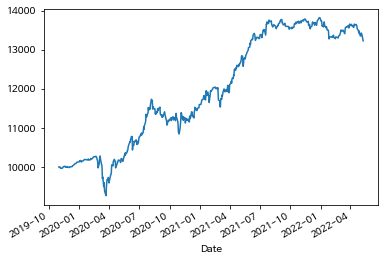

In [ ]:
log_df['kospi'].plot()

In [ ]:
log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]=log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']].cumsum()

In [ ]:
log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
Date,,,,,,,
2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427
2019-11-04,0.000168,-0.002161,0.022195,-0.002077,0.024486,-0.007237,-0.011898
2019-11-05,0.000232,-0.001148,0.027999,-0.018849,0.027029,-0.024367,-0.013624
2019-11-06,0.000255,-0.001098,0.028704,-0.013928,0.016176,-0.022196,0.001502
2019-11-07,0.000278,-0.001796,0.028769,-0.030188,0.015534,-0.032221,0.007589
...,...,...,...,...,...,...,...
2022-05-03,0.028070,-0.002431,0.251949,0.144817,0.652885,0.173650,0.408839
2022-05-04,0.028154,-0.003295,0.250870,0.154636,0.683612,0.185075,0.423056
2022-05-06,0.028263,-0.002294,0.238446,0.156597,0.684673,0.173135,0.406062


In [ ]:
# log_df

In [ ]:
log_df[['유동성', '레버리지','그레이엄', '린치', '버핏', '삼대투자','성장성', '수익성', '시장가치', '활동성']]=log_df[['유동성기법','레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']].cumsum()

In [ ]:
log_df[['유동성', '레버리지','그레이엄', '린치', '버핏', '삼대투자','성장성', '수익성', '시장가치', '활동성']]

,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,
2019-11-01,0.000157,0.014511,0.009174,0.005316,0.011783,0.007650,0.007974,0.013218,0.008100,0.014093
2019-11-04,0.014559,0.017529,0.009682,0.013768,0.010983,0.016482,0.022305,0.021752,0.016869,0.033270
2019-11-05,0.029178,0.017005,0.010386,0.017618,0.014818,0.014278,0.026445,0.028646,0.027458,0.038091
2019-11-06,0.028046,0.012199,0.006338,0.018060,0.007181,0.008609,0.040399,0.018273,0.029495,0.034984
2019-11-07,0.029493,0.013177,0.004559,0.020092,0.012194,0.013941,0.035563,0.018841,0.034695,0.042584
...,...,...,...,...,...,...,...,...,...,...
2022-05-03,-0.163004,-0.000938,0.369885,0.214558,0.190423,0.328249,0.154614,-0.225244,0.463448,0.034294
2022-05-04,-0.172324,-0.004683,0.363478,0.216346,0.186394,0.327273,0.155539,-0.228101,0.470279,0.036349
2022-05-06,-0.171246,-0.018417,0.357262,0.202860,0.173418,0.312220,0.141133,-0.240506,0.461915,0.030147


In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,0.000157,0.014511,0.009174,0.005316,0.011783,0.007650,0.007974,0.013218,0.008100,0.014093
2019-11-04,2019-11-04,0.000168,-0.002161,0.022195,-0.002077,0.024486,-0.007237,-0.011898,0.0,2130.239990,...,0.014559,0.017529,0.009682,0.013768,0.010983,0.016482,0.022305,0.021752,0.016869,0.033270
2019-11-05,2019-11-05,0.000232,-0.001148,0.027999,-0.018849,0.027029,-0.024367,-0.013624,0.0,2142.639893,...,0.029178,0.017005,0.010386,0.017618,0.014818,0.014278,0.026445,0.028646,0.027458,0.038091
2019-11-06,2019-11-06,0.000255,-0.001098,0.028704,-0.013928,0.016176,-0.022196,0.001502,0.0,2144.149902,...,0.028046,0.012199,0.006338,0.018060,0.007181,0.008609,0.040399,0.018273,0.029495,0.034984
2019-11-07,2019-11-07,0.000278,-0.001796,0.028769,-0.030188,0.015534,-0.032221,0.007589,0.0,2144.290039,...,0.029493,0.013177,0.004559,0.020092,0.012194,0.013941,0.035563,0.018841,0.034695,0.042584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,2022-05-03,0.028070,-0.002431,0.251949,0.144817,0.652885,0.173650,0.408839,0.0,2680.459961,...,-0.163004,-0.000938,0.369885,0.214558,0.190423,0.328249,0.154614,-0.225244,0.463448,0.034294
2022-05-04,2022-05-04,0.028154,-0.003295,0.250870,0.154636,0.683612,0.185075,0.423056,0.0,2677.570068,...,-0.172324,-0.004683,0.363478,0.216346,0.186394,0.327273,0.155539,-0.228101,0.470279,0.036349
2022-05-06,2022-05-06,0.028263,-0.002294,0.238446,0.156597,0.684673,0.173135,0.406062,0.0,2644.510010,...,-0.171246,-0.018417,0.357262,0.202860,0.173418,0.312220,0.141133,-0.240506,0.461915,0.030147


In [ ]:
# log_df[['단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw', 'nsdw','유동성기법', '레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법','성장성기법', '수익성기법', '시장가치기법', '활동성기법'
# ,'단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

In [ ]:
asdfasdfasdfasdfasdfasdfasdfasdfasdfasdfasd

NameError: ignored

In [ ]:
log_df['금액']=10000

In [ ]:
log_df['kospi']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['ksp로그'])
log_df['유동성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['유동성'])
log_df['레버리지추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['레버리지'])
log_df['그레이엄추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['그레이엄'])
log_df['린치추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['린치'])
log_df['버핏추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['버핏'])
log_df['삼대투자추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['삼대투자'])
log_df['성장성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['성장성'])
log_df['수익성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['수익성'])
log_df['시장가치추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['시장가치'])
log_df['활동성추이']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['활동성'])







In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그',
       '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw',
       'dbcw', 'vnqw', 'nsdw', '유동성', '레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성', '금액', 'kospi', '유동성추이', '레버리지추이', '그레이엄추이',
       '린치추이', '버핏추이', '삼대투자추이', '성장성추이', '수익성추이', '시장가치추이', '활동성추이'],
      dtype='object')

In [ ]:
log_df.loc['2021-07-30':'2021-08-30']

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,유동성추이,레버리지추이,그레이엄추이,린치추이,버핏추이,삼대투자추이,성장성추이,수익성추이,시장가치추이,활동성추이
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-30,2021-07-30,0.019651,0.030544,0.429836,0.141788,0.290890,0.226713,0.621976,1.0,3202.320068,...,14029.778495,14118.943148,14318.177615,14202.285470,14280.568147,14321.555935,14186.036105,13977.748385,14345.982304,14060.918383
2021-08-02,2021-08-02,0.019717,0.030212,0.436285,0.140919,0.280062,0.224547,0.631039,1.0,3223.040039,...,11880.003434,11977.833099,12192.099200,12062.049162,12158.862621,12204.559203,12070.479333,11815.851173,12236.738757,11907.492445
2021-08-03,2021-08-03,0.019727,0.030156,0.440651,0.139760,0.275386,0.225772,0.632312,1.0,3237.139893,...,11790.094311,11886.819232,12087.689087,11957.579518,12055.757084,12089.066586,11971.534458,11740.778666,12124.551778,11812.736351
2021-08-04,2021-08-04,0.019745,0.031027,0.453920,0.140340,0.259108,0.222659,0.635962,1.0,3280.379883,...,11765.721502,11868.457049,12072.586426,11952.574790,12035.760562,12083.412046,11960.803552,11714.416015,12118.333263,11793.163669
2021-08-05,2021-08-05,0.019744,0.031154,0.452623,0.135693,0.273822,0.234305,0.632365,1.0,3276.129883,...,11789.973203,11880.212495,12078.002026,11953.937947,12043.044853,12074.254463,11976.506489,11734.137651,12096.225882,11807.089680
2021-08-06,2021-08-06,0.019747,0.030454,0.450861,0.111233,0.265440,0.232529,0.632577,1.0,3270.360107,...,11687.923824,11774.840634,11964.421386,11845.426023,11944.780675,11965.529372,11886.222508,11623.349141,11982.933499,11694.936018
2021-08-09,2021-08-09,0.019818,0.030781,0.447816,0.092867,0.251135,0.227183,0.632365,1.0,3260.419922,...,11682.689200,11775.146741,11973.647938,11840.037918,11952.467626,11969.927068,11883.868770,11599.532164,11991.940317,11677.840995
2021-08-10,2021-08-10,0.019823,0.030985,0.442518,0.093475,0.269116,0.217640,0.633318,1.0,3243.189941,...,11760.170611,11859.537762,12082.969553,11936.586337,12068.187712,12070.700097,12013.937533,11681.739307,12098.023738,11757.093315
2021-08-11,2021-08-11,0.019845,0.031365,0.435534,0.107048,0.277986,0.223509,0.635751,1.0,3220.620117,...,11533.026922,11615.415395,11801.391913,11684.356317,11795.647353,11793.934519,11751.498300,11466.768652,11824.288618,11535.228728


In [ ]:
log_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피,...,유동성추이,레버리지추이,그레이엄추이,린치추이,버핏추이,삼대투자추이,성장성추이,수익성추이,시장가치추이,활동성추이
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,2019-11-01,0.000043,-0.000289,0.007993,0.000000,0.018100,-0.000212,-0.005427,0.0,2100.199951,...,10005.877717,10016.237357,10012.368302,10009.584540,10014.257292,10011.267287,10011.501533,10015.298426,10011.592307,10015.933950
2019-11-04,2019-11-04,0.000168,-0.002161,0.022195,-0.002077,0.024486,-0.007237,-0.011898,0.0,2130.239990,...,10003.400551,10005.492030,9999.979204,10002.843911,10000.889767,10004.754198,10008.868586,10008.477064,10005.026590,10016.682869
2019-11-05,2019-11-05,0.000232,-0.001148,0.027999,-0.018849,0.027029,-0.024367,-0.013624,0.0,2142.639893,...,9990.233015,9982.144756,9977.788106,9982.550007,9980.702551,9980.346633,9988.408628,9989.878056,9989.084501,9996.218174
2019-11-06,2019-11-06,0.000255,-0.001098,0.028704,-0.013928,0.016176,-0.022196,0.001502,0.0,2144.149902,...,9999.279027,9988.845858,9985.028929,9992.685267,9985.576100,9986.504880,10007.527266,9992.824894,10000.241006,10003.899310
2019-11-07,2019-11-07,0.000278,-0.001796,0.028769,-0.030188,0.015534,-0.032221,0.007589,0.0,2144.290039,...,9982.135902,9971.136561,9965.398828,9975.776345,9970.479407,9971.647666,9986.273645,9974.934566,9985.679978,9991.090977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,2022-05-03,0.028070,-0.002431,0.251949,0.144817,0.652885,0.173650,0.408839,0.0,2680.459961,...,11115.748900,11216.317388,11518.077368,11377.961303,11358.078307,11478.359376,11329.447496,11081.256562,11613.601758,11240.421794
2022-05-04,2022-05-04,0.028154,-0.003295,0.250870,0.154636,0.683612,0.185075,0.423056,0.0,2677.570068,...,11381.961910,11488.249699,11794.749060,11658.593283,11633.246554,11759.364680,11607.916670,11350.368830,11906.914491,11517.094210
2022-05-06,2022-05-06,0.028263,-0.002294,0.238446,0.156597,0.684673,0.173135,0.406062,0.0,2644.510010,...,11173.320451,11261.799795,11546.472445,11416.421942,11393.822523,11506.437723,11369.794912,11137.464742,11646.755448,11292.866983


In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그',
       '상승', '코스피', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw',
       'dbcw', 'vnqw', 'nsdw', '유동성w', '레버리지w', '그레이엄w', '린치w', '버핏w', '삼대투자w',
       '성장성w', '수익성w', '시장가치w', '활동성w', '금액', 'kospi', '유동성', '레버리지', '그레이엄',
       '린치', '버핏', '삼대투자', '성장성', '수익성', '시장가치', '활동성'],
      dtype='object')

In [ ]:
grp

,lstm_markowitz,kospi,미래에셋,KB펀드
Date,,,,
2019-10-04,10000.000000,10000.000000,10000.000000,10000.000000
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894


In [ ]:
# log_df.loc["2021-07-15":"2021-08-15"]

In [ ]:
# log_df.loc["2021-07-01":"2021-08-01"]
# 

In [ ]:
# log_df =log_df.drop('Date',axis=1)

In [ ]:
# grp = grp.drop(['level_0', 'index'], axis=1)

In [ ]:
예측가격 = pd.merge(grp,log_df[['kospi','유동성추이']],on='Date',how='outer').dropna()

In [ ]:
예측가격 = pd.merge(grp,log_df[['kospi','유동성추이', '레버리지추이', '그레이엄추이', '린치추이', '버핏추이', '삼대투자추이',
        '성장성추이', '수익성추이', '시장가치추이', '활동성추이']],on='Date',how='outer')

In [ ]:
예측가격

,lstm_markowitz,kospi_x,미래에셋,KB펀드,kospi_y,유동성추이
Date,,,,,,
2019-11-01,10174.847841,10393.479515,10227.294524,10080.015967,10000.000000,10000.000000
2019-11-29,10275.656197,10332.906193,10208.113551,10171.523403,9995.130281,9997.127563
2019-12-30,10535.811858,10875.839370,10873.693296,10341.156641,10126.836826,10112.738345
2020-01-28,10719.513308,10772.162152,10450.752853,10398.571566,10178.426071,10144.457984
2020-02-25,11011.285797,10410.355712,9849.429366,10309.944928,10186.419326,10145.938772
2020-03-24,7939.087352,7967.427054,7047.089287,9519.046916,9482.904600,9492.562064
2020-04-21,9710.769580,9300.684714,8463.604105,10296.889866,9976.186569,10060.078360
2020-05-19,9925.528961,9801.652123,8991.080848,10422.326894,10291.615623,10346.663484
2020-06-16,10293.127910,10580.792258,9233.720150,10523.844793,10658.819190,10723.333200


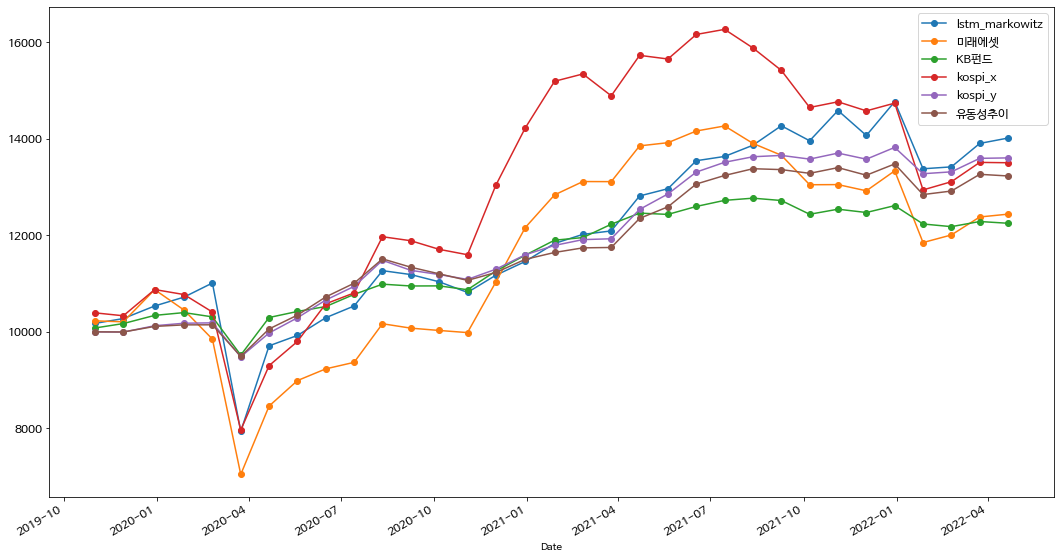

In [ ]:
p = 예측가격[['lstm_markowitz', '미래에셋', 'KB펀드','kospi_x' ,'kospi_y','유동성추이']].plot(figsize=(18, 10), style = '-o', fontsize=12)
p.legend(fontsize=12)
# plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()

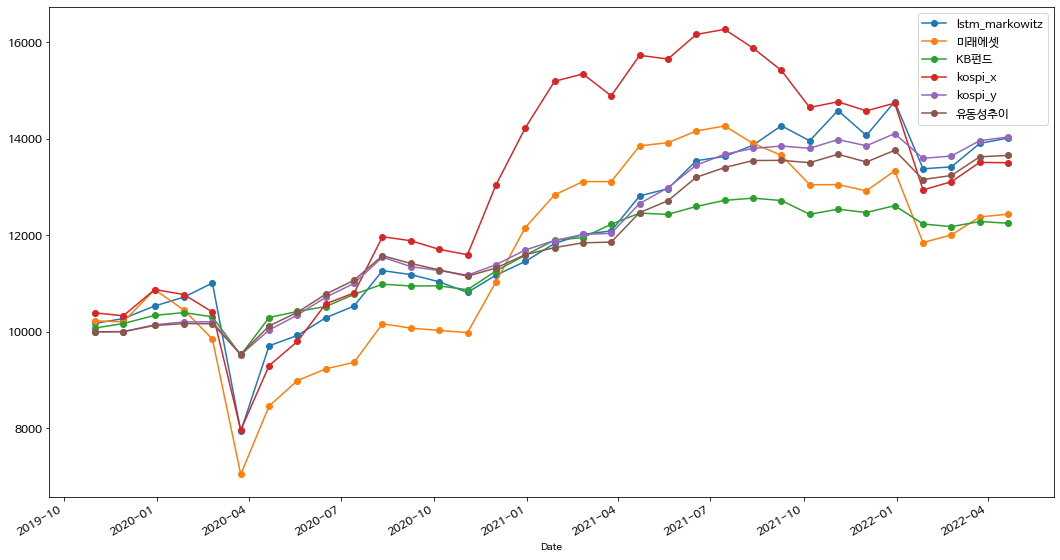

In [ ]:
p = 예측가격[['lstm_markowitz', '미래에셋', 'KB펀드','kospi_x' ,'kospi_y','유동성추이']].plot(figsize=(18, 10), style = '-o', fontsize=12)
p.legend(fontsize=12)
# plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()